In [211]:
#Imports
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium
from wordcloud import WordCloud, STOPWORDS
# from scipy import stats
import numpy as np
import re
import warnings
%matplotlib inline




In [212]:
# Set a global Seaborn theme
sns.set_theme(style="whitegrid")

# Generate a list of colors from a colormap (e.g., 'viridis')
n_colors = 10  
palette = sns.color_palette("viridis", n_colors=n_colors)

# Set this list of colors as the global palette
sns.set_palette(palette)

In [213]:
# Directory to save the plots
plot_dir = r'C:\Users\thisi\code\DataCareerAnalysis\plots'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
    
# plot_filename = os.path.join(plot_dir, 'plot1.png')
# plt.savefig(plot_filename)

In [214]:
#Load and Combine CSV Files and checking shape
data_path = r'C:\\Users\\thisi\\code\\DataCareerAnalysis\\data' 

# Use glob to get all the CSV file paths
csv_files = glob.glob(os.path.join(data_path, "*.csv"))

# List to hold the data frames
df_list = []

# Loop through the CSV files and read them into data frames
for file in csv_files:
    df = pd.read_csv(file)
    df_list.append(df)

# Concatenate all the data frames into one
df_combined = pd.concat(df_list, ignore_index=True)
df_original = df_combined
# df_combined = df_original # Revert to original 


print("Shape of df_combined:", df_combined.shape)
df_combined.head()


Shape of df_combined: (4183, 16)


,Keywords,Search Location,Job ID,Title,Company,City,Country,Type,Seniority,Posted,Collected Date,Applicants,Employees,Industry,Job URL,Job Description
0,Data Analyst,European Union,3927615333,Data Analyst Intern\r\nData Analyst Intern,Foxintelligence,Paris,France,On-site,Internship,2024-05-04,2024-08-02,100.0,51.0,Market Research,https://www.linkedin.com/jobs/search/?currentJ...,"""About the job\r\nChez Foxintelligence, nous s..."
1,Data Analyst,European Union,3985582505,Data Analyst Intern\r\nData Analyst Intern,Echo Analytics,Paris,France,On-site,NaN,2024-07-19,2024-08-02,0.0,51.0,Software Development,https://www.linkedin.com/jobs/search/?currentJ...,"""About the job\r\n🚀 Founded in 2021, Echo's na..."
2,Data Analyst,European Union,3988104437,Junior Data Analyst\r\nJunior Data Analyst,ISO,Cracow,Poland,On-site,Entry level,2024-07-31,2024-08-02,85.0,5001.0,Insurance,https://www.linkedin.com/jobs/search/?currentJ...,"""About the job\r\nCompany Description\r\n\r\nW..."
3,Data Analyst,European Union,3986942433,Junior Data Analyst\r\nJunior Data Analyst,Intale,Athens,Greece,On-site,Associate,2024-07-30,2024-08-02,100.0,11.0,IT Services and IT Consulting,https://www.linkedin.com/jobs/search/?currentJ...,"""About the job\r\nIntale is a VC backed retail..."
4,Data Analyst,European Union,3987193886,Data Analyst Intern\r\nData Analyst Intern wit...,Mirakl,Paris,France,On-site,NaN,2024-07-30,2024-08-02,93.0,501.0,Software Development,https://www.linkedin.com/jobs/search/?currentJ...,"""About the job\r\nMirakl is the global leader ..."


In [215]:
# Cleaning new line '\n' from Title and Job Description columns
df_combined.loc[:, ['Title', 'Job Description']] = df_combined.loc[:, ['Title', 'Job Description']].replace('\n', ' ', regex=True)

# Removing 'full time', 'contract' from Seniority column
df_combined.loc[:, 'Seniority'] = df_combined['Seniority'].replace(['Contract', 'Full-time', 'Temporary'], 'N/A', regex=True)
df_combined.loc[:, 'Seniority'] = df_combined['Seniority'].replace('N/A', 'Info Not Provided', regex=True)

# Convert dates to Dateframe
df_combined.loc[:, 'Posted'] = pd.to_datetime(df_combined['Posted'])
df_combined.loc[:, 'Collected Date'] = pd.to_datetime(df_combined['Collected Date'])

# Fill NaN values in Employees and Applicants
df_combined.loc[:, ['Employees', 'Applicants']] = df_combined.loc[:, ['Employees', 'Applicants']].fillna(0)

nan_counts = df_combined.isna().sum()
print('\nNaN counts per Column')
print(nan_counts)

# Convert Applicants & Employee Column TYPE (Floats > Integers)
df_combined.loc[:, ['Employees', 'Applicants']] = df_combined.loc[:, ['Employees', 'Applicants']].astype(int)

# Print column types
print('\nColumn Types')
print(df_combined.dtypes)

# Count instances of each unique value in 'Keywords' column
# keywords_counts = df_combined['Keywords'].value_counts()
# print('\nInstances of each unique keyword:')
# print(keywords_counts)



NaN counts per Column
Keywords             0
Search Location      0
Job ID               0
Title                0
Company              0
City                 0
Country            900
Type                 0
Seniority          922
Posted             107
Collected Date       0
Applicants           0
Employees            0
Industry            72
Job URL              0
Job Description      0
dtype: int64

Column Types
Keywords            object
Search Location     object
Job ID               int64
Title               object
Company             object
City                object
Country             object
Type                object
Seniority           object
Posted              object
Collected Date      object
Applicants         float64
Employees          float64
Industry            object
Job URL             object
Job Description     object
dtype: object


In [216]:
# Function to find duplicates / recruitment spamming
def find_duplicate_postings(df):
    # Group by 'Company' and 'Title' and filter out duplicates
    duplicates = df.groupby(['Company', 'Title']).filter(lambda x: len(x) > 1)
    
    # Sort the duplicates by 'Title'
    duplicates_sorted = duplicates.sort_values(by='Title')
    
    return duplicates_sorted

# Function to remove duplicate postings, keeping only one per combination of 'Company' and 'Title'
def remove_duplicate_postings(df):
    # Drop duplicates, keeping the first occurrence
    df_unique = df.drop_duplicates(subset=['Company', 'Title'], keep='first')
    
    return df_unique

# Find duplicates (optional step if you want to inspect duplicates first)
duplicate_postings_df = find_duplicate_postings(df_combined)

# Remove duplicates, keeping only one per combination of 'Company' and 'Title'
df_combined_unique = remove_duplicate_postings(df_combined)

# Display the DataFrame with duplicates removed
df_combined_unique
df_combined = df_combined_unique



In [217]:
# Cleaned Data.head()
df_combined.head()
# df_combined

,Keywords,Search Location,Job ID,Title,Company,City,Country,Type,Seniority,Posted,Collected Date,Applicants,Employees,Industry,Job URL,Job Description
0,Data Analyst,European Union,3927615333,Data Analyst Intern\r Data Analyst Intern,Foxintelligence,Paris,France,On-site,Internship,2024-05-04 00:00:00,2024-08-02 00:00:00,100.0,51.0,Market Research,https://www.linkedin.com/jobs/search/?currentJ...,"""About the job\r Chez Foxintelligence, nous so..."
1,Data Analyst,European Union,3985582505,Data Analyst Intern\r Data Analyst Intern,Echo Analytics,Paris,France,On-site,NaN,2024-07-19 00:00:00,2024-08-02 00:00:00,0.0,51.0,Software Development,https://www.linkedin.com/jobs/search/?currentJ...,"""About the job\r 🚀 Founded in 2021, Echo's nar..."
2,Data Analyst,European Union,3988104437,Junior Data Analyst\r Junior Data Analyst,ISO,Cracow,Poland,On-site,Entry level,2024-07-31 00:00:00,2024-08-02 00:00:00,85.0,5001.0,Insurance,https://www.linkedin.com/jobs/search/?currentJ...,"""About the job\r Company Description\r \r We h..."
3,Data Analyst,European Union,3986942433,Junior Data Analyst\r Junior Data Analyst,Intale,Athens,Greece,On-site,Associate,2024-07-30 00:00:00,2024-08-02 00:00:00,100.0,11.0,IT Services and IT Consulting,https://www.linkedin.com/jobs/search/?currentJ...,"""About the job\r Intale is a VC backed retail-..."
4,Data Analyst,European Union,3987193886,Data Analyst Intern\r Data Analyst Intern with...,Mirakl,Paris,France,On-site,NaN,2024-07-30 00:00:00,2024-08-02 00:00:00,93.0,501.0,Software Development,https://www.linkedin.com/jobs/search/?currentJ...,"""About the job\r Mirakl is the global leader i..."


Initial Exploration 

In [218]:
# Count instances of each unique value in 'Keywords' column and Describe 
keywords_counts = df_combined['Keywords'].value_counts()
print('\nInstances of each unique keyword:')
print(keywords_counts)

df_combined.describe()


Instances of each unique keyword:
Keywords
Data Scientist               512
Data Engineer                497
Data Analyst                 412
Machine Learning Engineer    402
Name: count, dtype: int64


,Job ID,Applicants,Employees
count,1.823000e+03,1823.000000,1823.000000
mean,3.961556e+09,48.978607,1873.731212
std,5.604920e+07,42.076809,3435.826418
min,3.114762e+09,0.000000,0.000000
25%,3.964312e+09,2.000000,11.000000
50%,3.977566e+09,43.000000,201.000000
75%,3.986549e+09,100.000000,1001.000000
max,3.991547e+09,100.000000,10001.000000


# Job Posting counts by country 

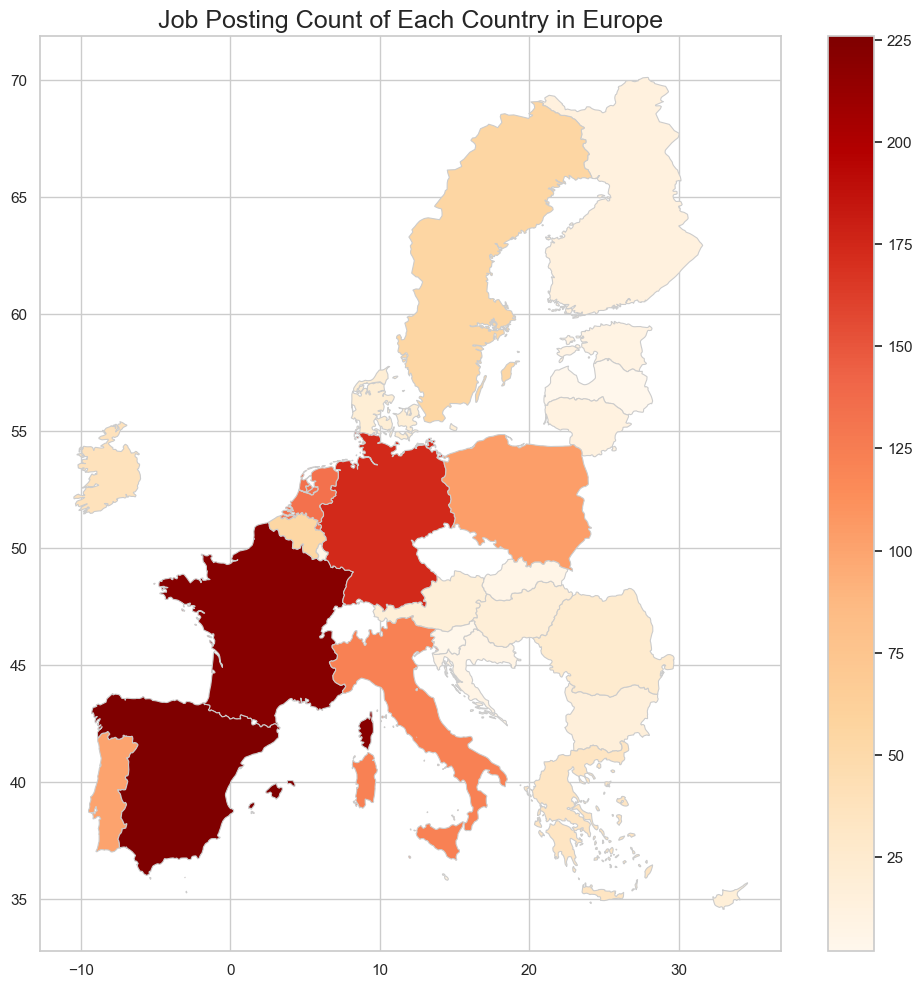

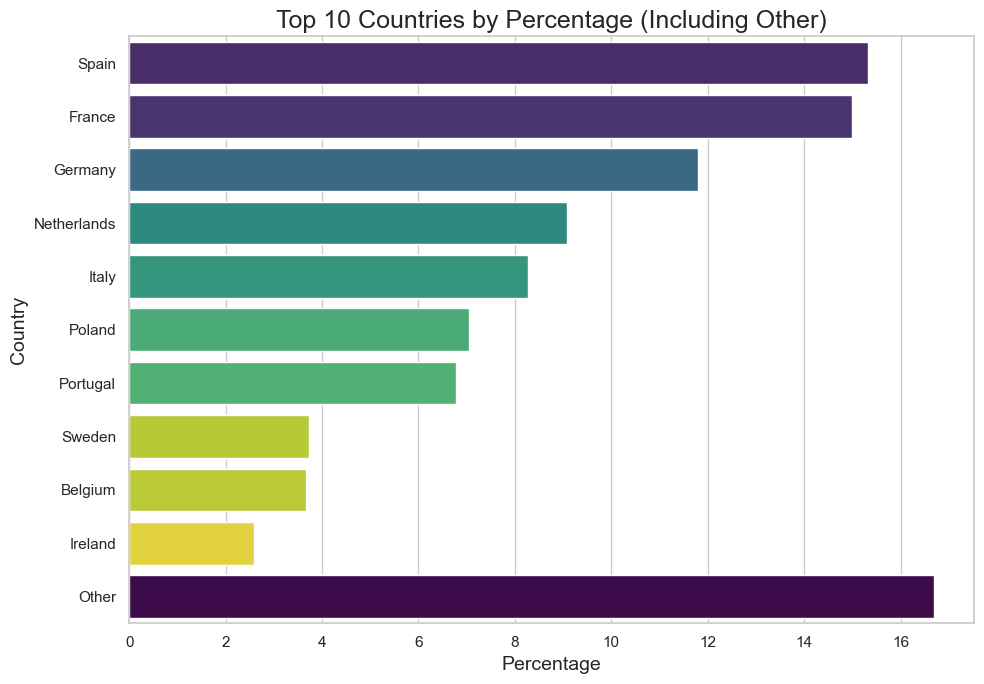

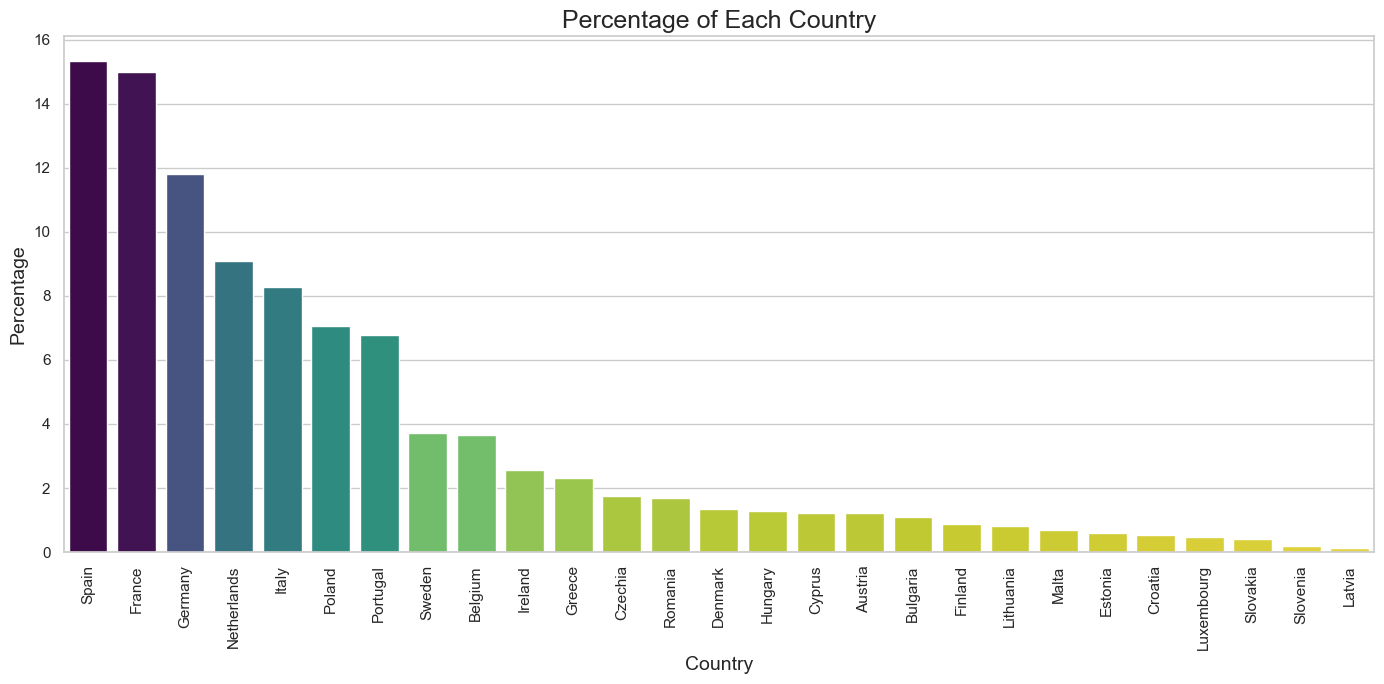

In [219]:
# Define plot directory
plot_dir = 'C:\\Users\\thisi\\code\\DataCareerAnalysis\\plots'  # Update this path as needed

# Job Offerings by Country
# Count instances of each country and convert to DataFrame
counts_df = df_combined['Country'].value_counts().reset_index()
counts_df.columns = ['Country', 'Count']
counts_df['Percentage'] = (counts_df['Count'] / counts_df['Count'].sum()) * 100

# Load Europe GeoJSON and merge with counts data
geojson_path = 'C:\\Users\\thisi\\code\\DataCareerAnalysis\\assets\\europe.geojson'
eu_countries = gpd.read_file(geojson_path)
merged = eu_countries.set_index('NAME').join(counts_df.set_index('Country'))

# Plot geographical map
fig, ax = plt.subplots(figsize=(10, 10))
merged.plot(column='Count', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_title('Job Posting Count of Each Country in Europe', fontsize=18)
plt.tight_layout()

# Save the map plot
map_plot_filename = os.path.join(plot_dir, 'Job Posting Count of Each Country in Europe.png')
plt.savefig(map_plot_filename)
plt.show()

# Prepare colors for top 10 countries
top_counts_df = counts_df.sort_values(by='Percentage', ascending=False).head(10)
other_percentage = counts_df.iloc[10:]['Percentage'].sum()

# Create 'Other' category DataFrame
other_df = pd.DataFrame({'Country': ['Other'], 'Percentage': [other_percentage]})

# Concatenate the top 10 countries with the 'Other' category
top_counts_df = pd.concat([top_counts_df, other_df], ignore_index=True)

# Reverse the colormap and prepare colors for the top 10 countries
cmap = plt.get_cmap('viridis_r')  # Reverse the colormap
norm_top = Normalize(vmin=top_counts_df['Percentage'].min(), vmax=top_counts_df['Percentage'].max())
colors_top = cmap(norm_top(top_counts_df['Percentage']))

# Convert colors to hexadecimal
colors_top_hex = [mcolors.rgb2hex(color) for color in colors_top]

# Plot bar chart for top 10 countries with 'Other'
plt.figure(figsize=(10, 7))
sns.barplot(x='Percentage', y='Country', data=top_counts_df, hue='Country', dodge=False, palette=colors_top_hex)
plt.xlabel('Percentage', fontsize=14)
plt.ylabel('Country', fontsize=14)
plt.title('Top 10 Countries by Percentage (Including Other)', fontsize=18)
plt.tight_layout()

# Save the bar plot for top 10 countries
bar_plot_filename = os.path.join(plot_dir, 'Top 10 Countries by Percentage.png')
plt.savefig(bar_plot_filename)
plt.show()

# Plot bar chart for all countries
norm_all = Normalize(vmin=counts_df['Percentage'].min(), vmax=counts_df['Percentage'].max())
colors_all = cmap(norm_all(counts_df['Percentage']))

# Convert colors to hexadecimal
colors_all_hex = [mcolors.rgb2hex(color) for color in colors_all]

plt.figure(figsize=(14, 7))
sns.barplot(x='Country', y='Percentage', data=counts_df, hue='Country', dodge=False, palette=colors_all_hex)
plt.xlabel('Country', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.title('Percentage of Each Country', fontsize=18)
plt.xticks(rotation=90)
plt.tight_layout()

# Save the bar plot for all countries
all_countries_plot_filename = os.path.join(plot_dir, 'Percentage of Each Country.png')
plt.savefig(all_countries_plot_filename)
plt.show()


# Onsite or Remote distribution  

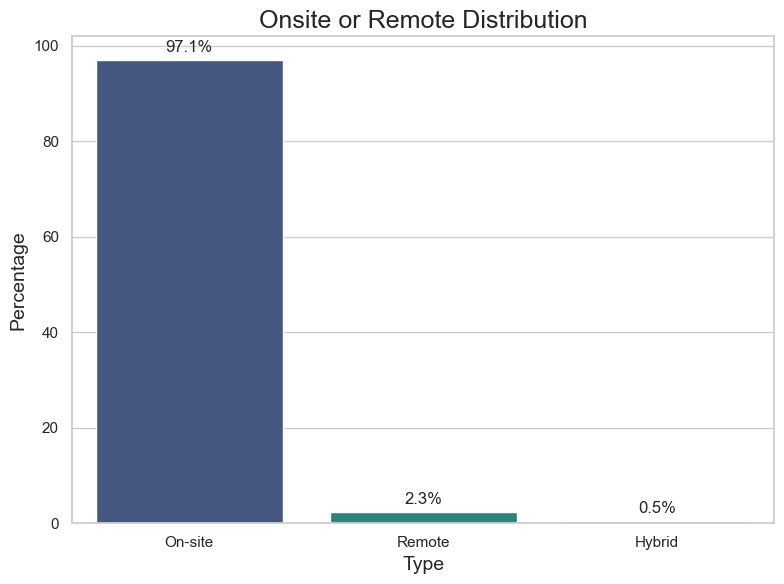

In [220]:
# Calculate the distribution of 'Type'
remote_distribution = df_combined['Type'].value_counts(normalize=True) * 100  # Calculate percentages

# Convert the Series to a DataFrame for easier plotting
remote_distribution_df = remote_distribution.reset_index()
remote_distribution_df.columns = ['Type', 'Percentage']

# Plotting the bar chart using Seaborn
plt.figure(figsize=(8, 6))
barplot = sns.barplot(x='Type', y='Percentage', data=remote_distribution_df, hue='Type', palette='viridis', dodge=False, legend=False)
plt.xlabel('Type', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.title('Onsite or Remote Distribution', fontsize=18)
plt.tight_layout()

# Add percentage annotations on each bar
for p in barplot.patches:
    percentage = f'{p.get_height():.1f}%'  # Format as percentage
    barplot.annotate(
        percentage, 
        (p.get_x() + p.get_width() / 2., p.get_height()),  # Position at the top of the bar
        ha='center', va='center', 
        xytext=(0, 9),  # Offset the text slightly above the bar
        textcoords='offset points',
        fontsize=12
    )

# Save the bar plot
plot_filename = os.path.join(plot_dir, 'Onsite or Remote Distribution Bar Chart.png')
plt.savefig(plot_filename)
plt.show()


## Correlation between company size and remote job offerings 


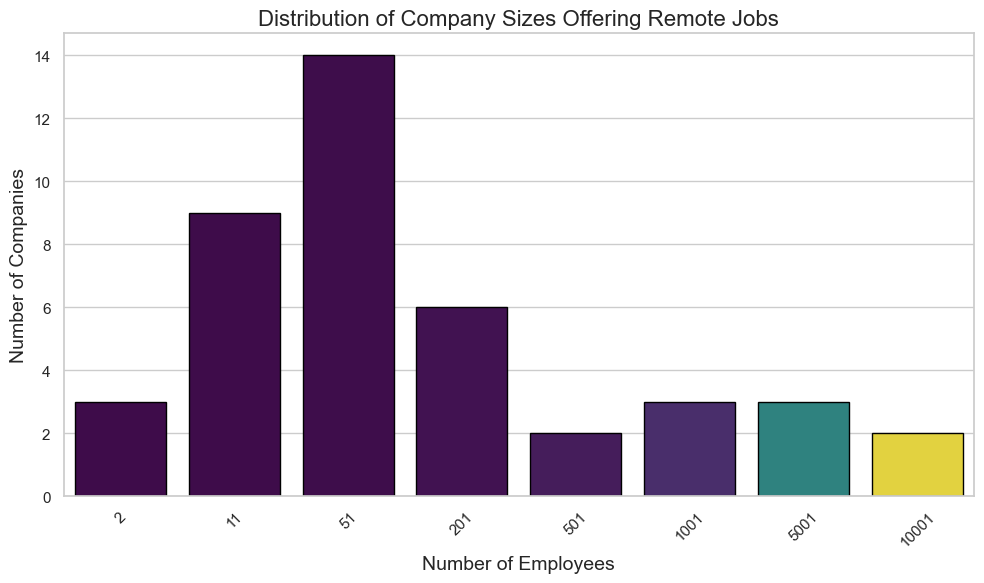

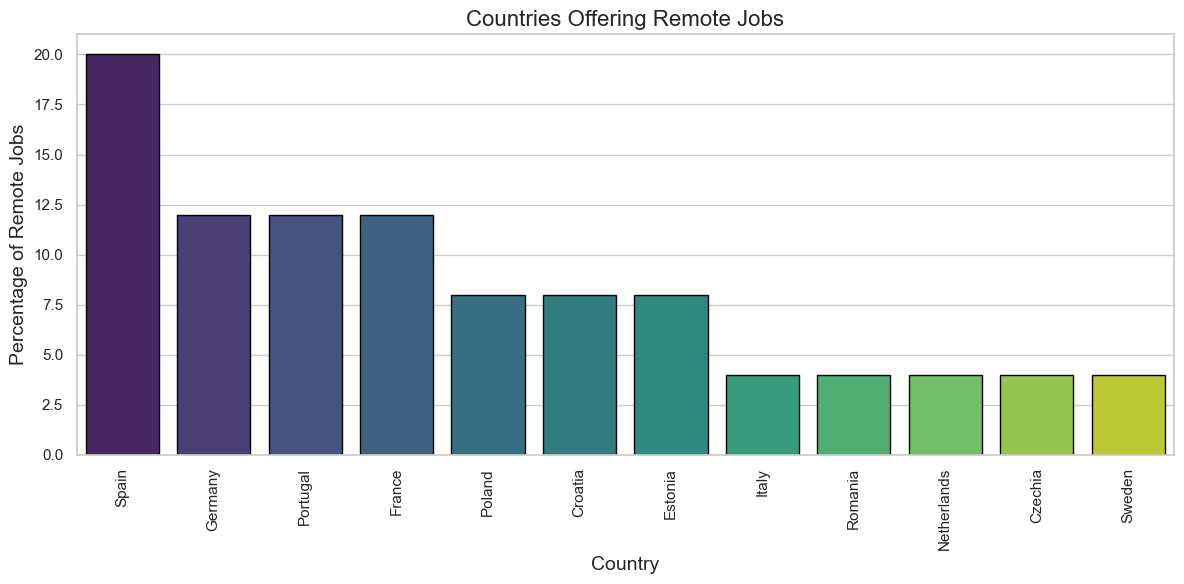

In [221]:
# Filter the dataset for remote jobs
remote_jobs = df_combined[df_combined['Type'] == 'Remote']

# Plotting the distribution of company sizes for remote jobs using Seaborn
plt.figure(figsize=(10, 6))
barplot = sns.countplot(
    x='Employees', 
    data=remote_jobs, 
    order=remote_jobs['Employees'].value_counts().sort_index().index, 
    palette='viridis', 
    edgecolor='black', 
    hue='Employees',
    dodge=False,
    legend=False
)

# Customize the x-axis to display whole numbers and avoid FixedFormatter warning
barplot.set_xticks(range(len(remote_jobs['Employees'].value_counts().sort_index().index)))
barplot.set_xticklabels([str(int(label)) for label in remote_jobs['Employees'].value_counts().sort_index().index])

plt.title('Distribution of Company Sizes Offering Remote Jobs', fontsize=16)
plt.xlabel('Number of Employees', fontsize=14)
plt.ylabel('Number of Companies', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot
plot_filename = os.path.join(plot_dir, 'Distribution of Company Sizes Offering Remote Jobs.png')
plt.savefig(plot_filename)
plt.show()

# Calculate the percentage of remote jobs per country and round to whole numbers
country_distribution = remote_jobs['Country'].value_counts(normalize=True) * 100
country_distribution = country_distribution.round().astype(int)  # Convert to whole numbers

# Convert the Series to a DataFrame for easier plotting
country_distribution_df = country_distribution.reset_index()
country_distribution_df.columns = ['Country', 'Percentage']

# Plotting the countries offering remote roles using Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(
    x='Country', 
    y='Percentage', 
    data=country_distribution_df, 
    palette='viridis', 
    edgecolor='black', 
    hue='Country', 
    dodge=False, 
    legend=False
)
plt.title('Countries Offering Remote Jobs', fontsize=16)
plt.xlabel('Country', fontsize=14)
plt.ylabel('Percentage of Remote Jobs', fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()

# Save the plot
plot_filename = os.path.join(plot_dir, 'Percentage of Remote Jobs by Country.png')
plt.savefig(plot_filename)
plt.show()


## Distribution of remote work between job titles 


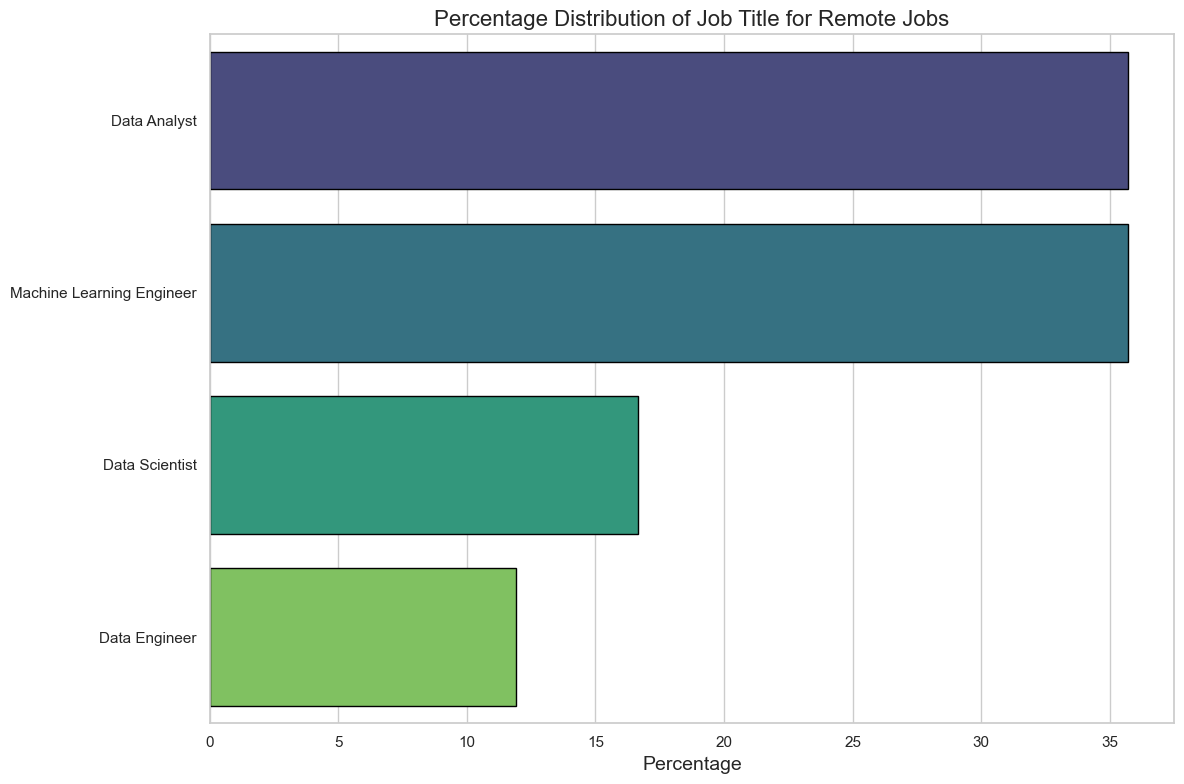

In [222]:
# Distribution of remote work between job titles 
# Filter the dataset for remote jobs
remote_jobs = df_combined[df_combined['Type'] == 'Remote']

# Calculate the percentage distribution of the 'Keywords' column
keywords_distribution = remote_jobs['Keywords'].value_counts(normalize=True) * 100
keywords_distribution = keywords_distribution.reset_index()
keywords_distribution.columns = ['Keywords', 'Percentage']

# Plotting the percentage distribution of 'Keywords' for remote jobs using Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Percentage', 
    y='Keywords', 
    data=keywords_distribution, 
    palette='viridis', 
    edgecolor='black', 
    hue='Keywords', 
    dodge=False, 
    legend=False
)

plt.title('Percentage Distribution of Job Title for Remote Jobs', fontsize=16)
plt.xlabel('Percentage', fontsize=14)
plt.ylabel('', fontsize=14)
plt.tight_layout()

# Save the plot
plot_filename = os.path.join(plot_dir, 'Percentage Distribution of Job Title for Remote Jobs.png')
plt.savefig(plot_filename)
plt.show()


## Count of Each Job Title by Seniority for Remote Jobs

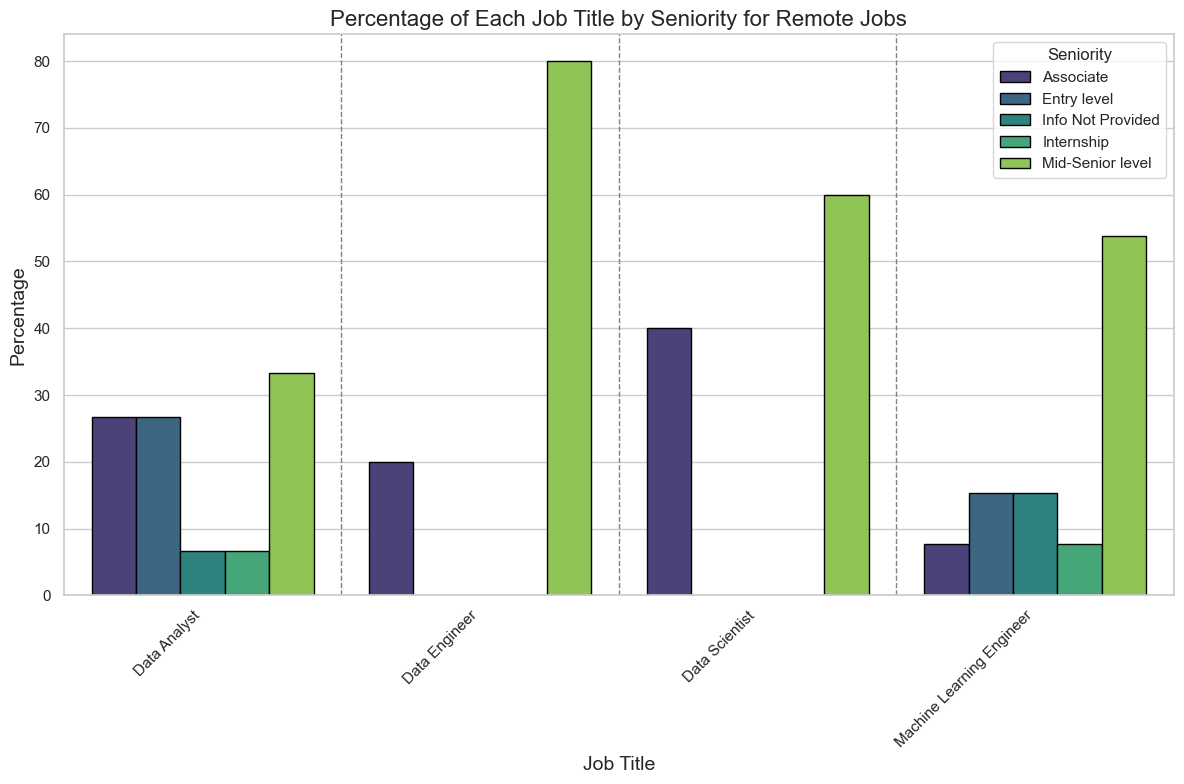

In [223]:
# Group by 'Keywords' and 'Seniority' and calculate the percentages
job_seniority_counts = remote_jobs.groupby(['Keywords', 'Seniority']).size().reset_index(name='Count')
total_counts = job_seniority_counts.groupby('Keywords')['Count'].transform('sum')
job_seniority_counts['Percentage'] = (job_seniority_counts['Count'] / total_counts) * 100

# Plotting the percentage of each job title by seniority using Seaborn
plt.figure(figsize=(12, 8))
barplot = sns.barplot(
    x='Keywords', 
    y='Percentage', 
    hue='Seniority', 
    data=job_seniority_counts, 
    palette='viridis', 
    edgecolor='black'
)

plt.title('Percentage of Each Job Title by Seniority for Remote Jobs', fontsize=16)
plt.xlabel('Job Title', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Seniority')

# Add vertical lines between job title groups
unique_keywords = job_seniority_counts['Keywords'].unique()
for i in range(1, len(unique_keywords)):
    plt.axvline(x=i - 0.5, color='grey', linestyle='--', linewidth=1)

plt.tight_layout()

# Save the plot
plot_filename = os.path.join(plot_dir, 'Percentage of Each Job Title by Seniority for Remote Jobs.png')
plt.savefig(plot_filename)
plt.show()




### Machine Learning and Data Analyst Remote jobs by Seniority 

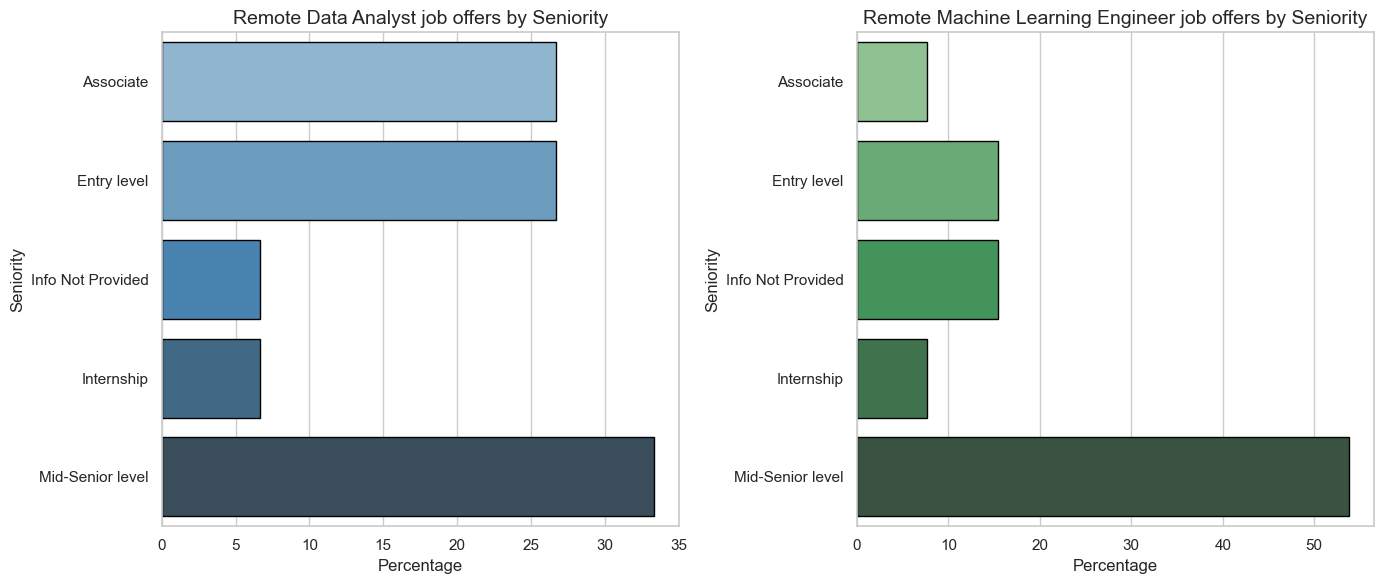

In [224]:
# Group by 'Keywords' and 'Seniority' and calculate the counts
job_seniority_counts = remote_jobs.groupby(['Keywords', 'Seniority']).size().unstack(fill_value=0)

# Filter for Data Analyst and Machine Learning Engineer and calculate percentages
data_analyst_counts = job_seniority_counts.loc['Data Analyst'].reset_index()
ml_engineer_counts = job_seniority_counts.loc['Machine Learning Engineer'].reset_index()

data_analyst_counts.columns = ['Seniority', 'Count']
ml_engineer_counts.columns = ['Seniority', 'Count']

data_analyst_counts['Percentage'] = (data_analyst_counts['Count'] / data_analyst_counts['Count'].sum()) * 100
ml_engineer_counts['Percentage'] = (ml_engineer_counts['Count'] / ml_engineer_counts['Count'].sum()) * 100

# Plotting the percentage bar charts using Seaborn
plt.figure(figsize=(14, 6))

# Data Analyst bar chart
plt.subplot(1, 2, 1)
sns.barplot(
    x='Percentage', 
    y='Seniority', 
    data=data_analyst_counts, 
    palette='Blues_d', 
    edgecolor='black',
    hue='Seniority',
    dodge=False,
    legend=False
)
plt.title('Remote Data Analyst job offers by Seniority', fontsize=14)
plt.xlabel('Percentage', fontsize=12)
plt.ylabel('Seniority', fontsize=12)

# Machine Learning Engineer bar chart
plt.subplot(1, 2, 2)
sns.barplot(
    x='Percentage', 
    y='Seniority', 
    data=ml_engineer_counts, 
    palette='Greens_d', 
    edgecolor='black',
    hue='Seniority',
    dodge=False,
    legend=False
)
plt.title('Remote Machine Learning Engineer job offers by Seniority', fontsize=14)
plt.xlabel('Percentage', fontsize=12)
plt.ylabel('Seniority', fontsize=12)

plt.tight_layout()
plot_filename = os.path.join(plot_dir, 'Remote Machine Learning and Analyst job offers by Seniority.png')
plt.savefig(plot_filename)
plt.show()


## Posting Distribution by Industry  

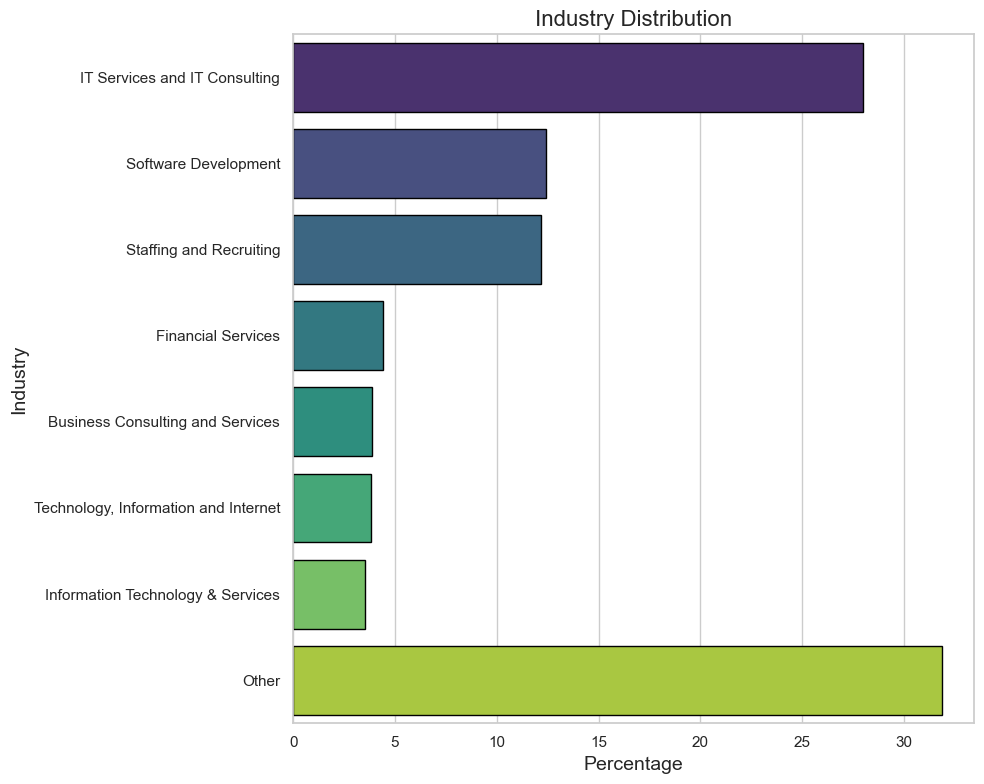

In [225]:
# Count the instances of each industry
industry_distribution = df_combined['Industry'].value_counts()

# Set a threshold to remove smaller percentages 
threshold = 50  

# Group smaller values into 'Other'
above_threshold = industry_distribution[industry_distribution > threshold]
below_threshold = industry_distribution[industry_distribution <= threshold]

# Create a new Series including the 'Other' category
other_sum = pd.Series(below_threshold.sum(), index=['Other'])
combined_distribution = pd.concat([above_threshold, other_sum])

# Convert to DataFrame and calculate percentages for easier plotting with Seaborn
combined_distribution_df = combined_distribution.reset_index()
combined_distribution_df.columns = ['Industry', 'Count']
combined_distribution_df['Percentage'] = (combined_distribution_df['Count'] / combined_distribution_df['Count'].sum()) * 100

# Plot using Seaborn
plt.figure(figsize=(10, 8))
sns.barplot(
    x='Percentage', 
    y='Industry', 
    data=combined_distribution_df, 
    palette='viridis', 
    edgecolor='black',
    hue='Industry',  # Assign hue to Industry
    dodge=False,     # Ensure bars are not dodged
    legend=False     # Disable legend
)
plt.title('Industry Distribution', fontsize=16)
plt.xlabel('Percentage', fontsize=14)
plt.ylabel('Industry', fontsize=14)
plt.tight_layout()

# Save the plot
plot_filename = os.path.join(plot_dir, 'Industry Distribution.png')
plt.savefig(plot_filename)
plt.show()


## Job posting count by largest three industries 

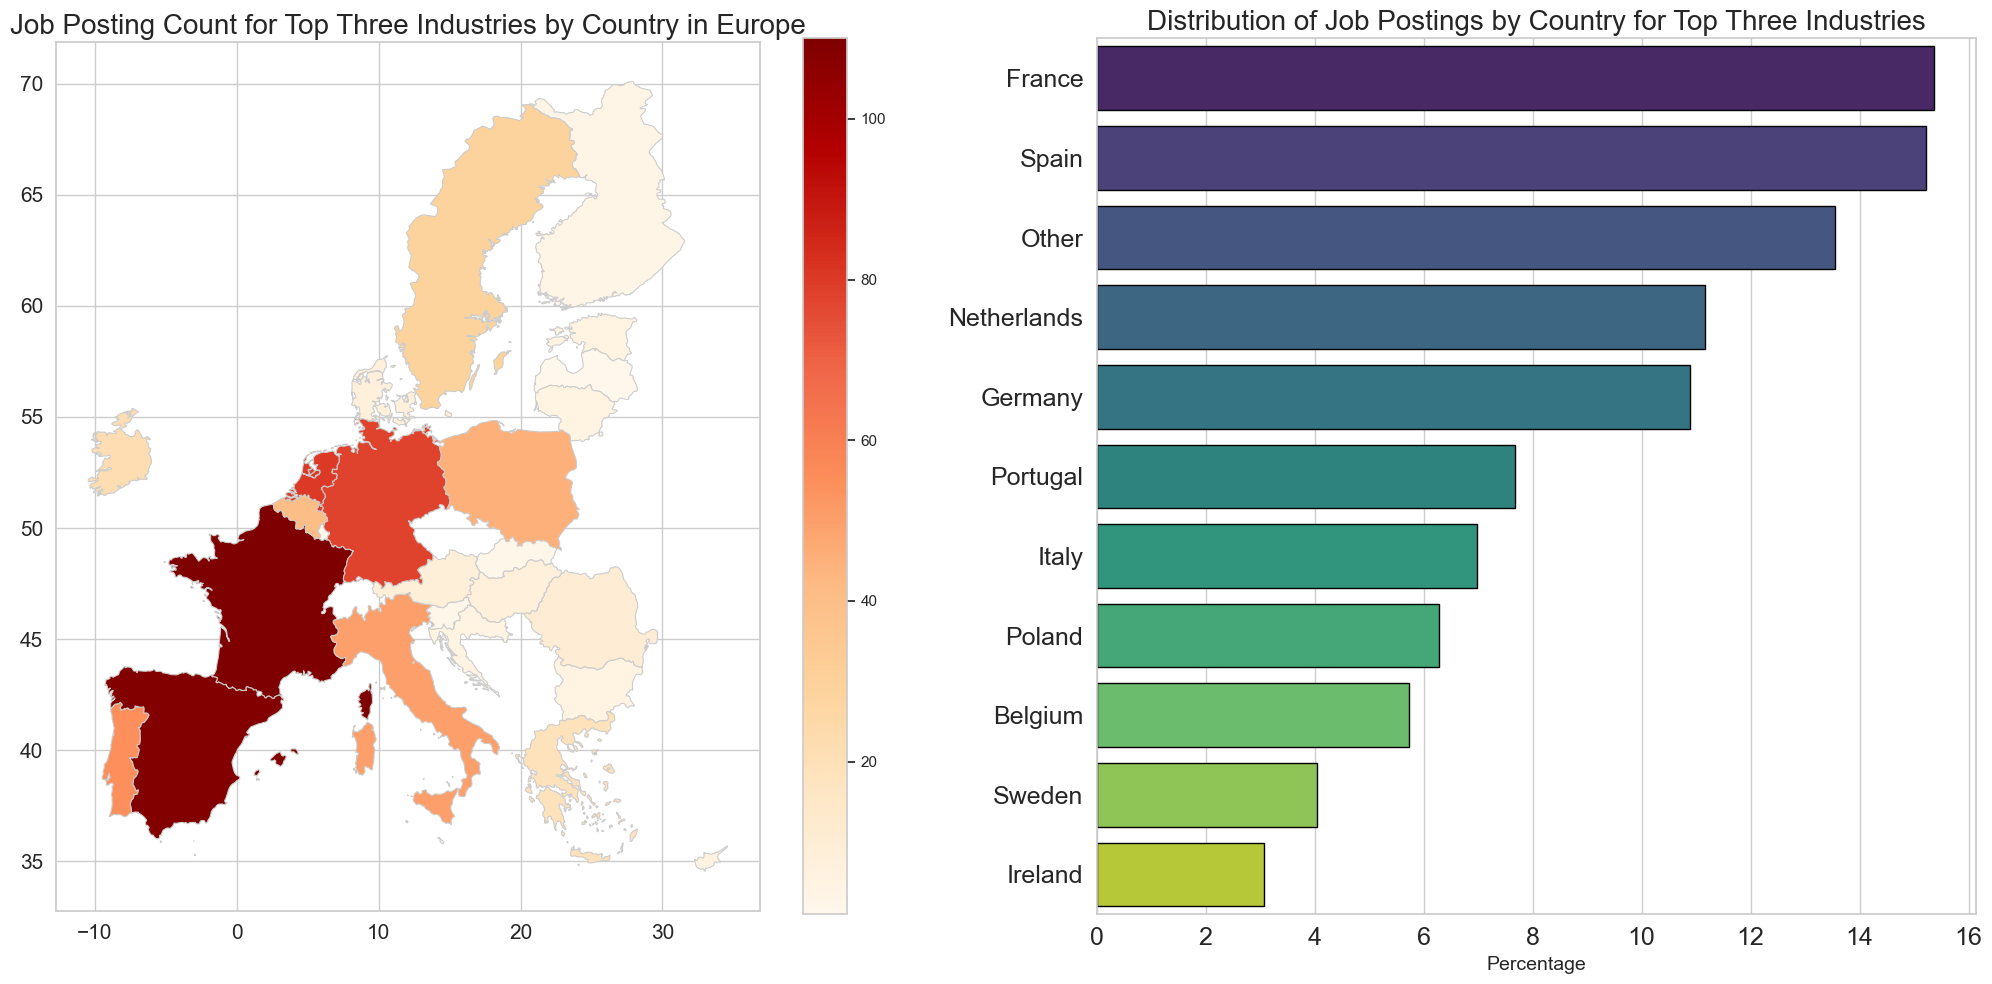

In [226]:
# Filter the dataset for the selected industries
selected_industries = ['IT Services and IT Consulting', 'Software Development', 'Staffing and Recruiting']
filtered_jobs = df_combined[df_combined['Industry'].isin(selected_industries)]

# Count the instances of each country for the selected industries
country_counts = filtered_jobs['Country'].value_counts()

# Convert to DataFrame
counts_df = pd.DataFrame(country_counts).reset_index()
counts_df.columns = ['Country', 'Count']

# Group smaller slices into 'Other'
total_count = counts_df['Count'].sum()
threshold = 0.03 * total_count

counts_df['Category'] = counts_df.apply(lambda row: row['Country'] if row['Count'] >= threshold else 'Other', axis=1)
grouped_counts_df = counts_df.groupby('Category').sum().reset_index()

# Sort by count in descending order
sorted_counts_df = grouped_counts_df.sort_values(by='Count', ascending=False)

# Calculate the percentage
sorted_counts_df['Percentage'] = (sorted_counts_df['Count'] / sorted_counts_df['Count'].sum()) * 100

# Plot the map and bar chart
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Plotting the geographical map
geojson_path = 'C:\\Users\\thisi\\code\\DataCareerAnalysis\\assets\\europe.geojson'
eu_countries = gpd.read_file(geojson_path)
merged = eu_countries.set_index('NAME').join(counts_df.set_index('Country'))

heatmap = merged.plot(column='Count', cmap='OrRd', linewidth=0.8, ax=ax[0], edgecolor='0.8', legend=True)
ax[0].set_title('Job Posting Count for Top Three Industries by Country in Europe', fontsize=20)
ax[0].tick_params(axis='both', which='major', labelsize=15)

# Increase font size for the color bar
cbar = heatmap.get_figure().get_axes()[1]
cbar.tick_params(labelsize=18)

# Plotting the bar chart using Seaborn
sns.barplot(
    x='Percentage', 
    y='Category', 
    data=sorted_counts_df, 
    palette='viridis', 
    edgecolor='black',
    hue='Category',  # Assign hue to Category
    dodge=False,     # Ensure bars are not dodged
    legend=False     # Disable legend
)
ax[1].set_title('Distribution of Job Postings by Country for Top Three Industries', fontsize=20)
ax[1].set_xlabel('Percentage', fontsize=14)
ax[1].set_ylabel(' ', fontsize=14)

# Adjust the layout
plt.tight_layout()

# Save and show the plot
plot_filename = os.path.join(plot_dir, 'Distribution of Job Postings by Country for Top Three Industries.png')
plt.savefig(plot_filename)
plt.show()


## Percentage Distribution of Top 10 Companies

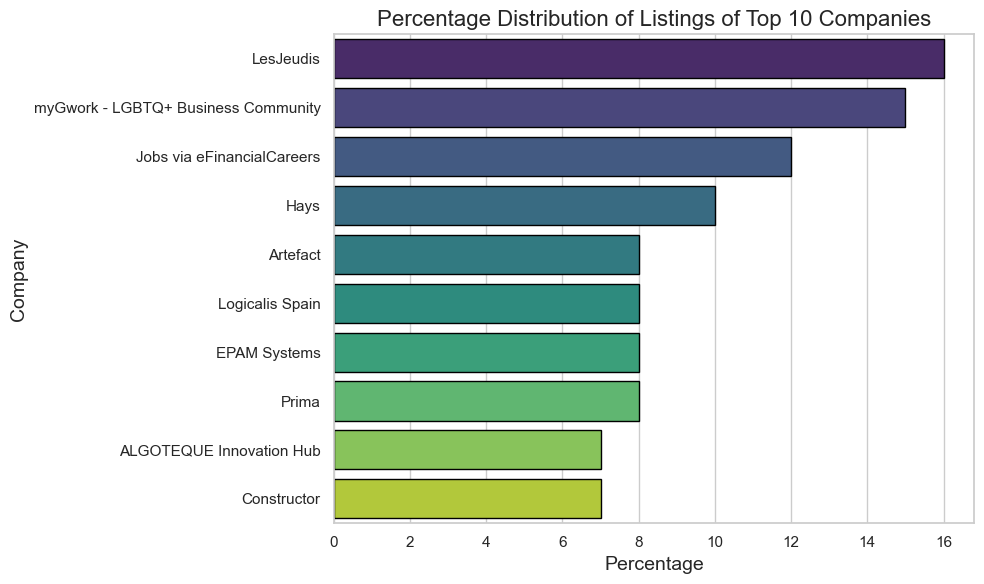

In [227]:
# Calculate the frequency of each company
company_counts = df_combined['Company'].value_counts()

# Filter to show only the top 10 companies
top_companies = company_counts.head(10).reset_index()
top_companies.columns = ['Company', 'Count']

# Calculate the percentage for the first graph, round to whole numbers, and convert to integer
top_companies['Percentage'] = ((top_companies['Count'] / top_companies['Count'].sum()) * 100).round().astype(int)

# Plotting the percentage distribution of the top 10 companies using Seaborn (Horizontal Bar Chart)
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Percentage', 
    y='Company', 
    data=top_companies, 
    palette='viridis', 
    edgecolor='black',
    hue='Company',  # Assign hue to Company
    dodge=False,     # Ensure bars are not dodged
    legend=False     # Disable legend
)
plt.xlabel('Percentage', fontsize=14)
plt.ylabel('Company', fontsize=14)
plt.title('Percentage Distribution of Listings of Top 10 Companies', fontsize=16)
plt.tight_layout()

# Save and show the horizontal bar plot
bar_plot_filename = os.path.join(plot_dir, 'Percentage_Distribution_of_Top_10_Companies_Bar_Horizontal.png')
plt.savefig(bar_plot_filename)
plt.show()


## Percentage of Seniority Levels per Job Title

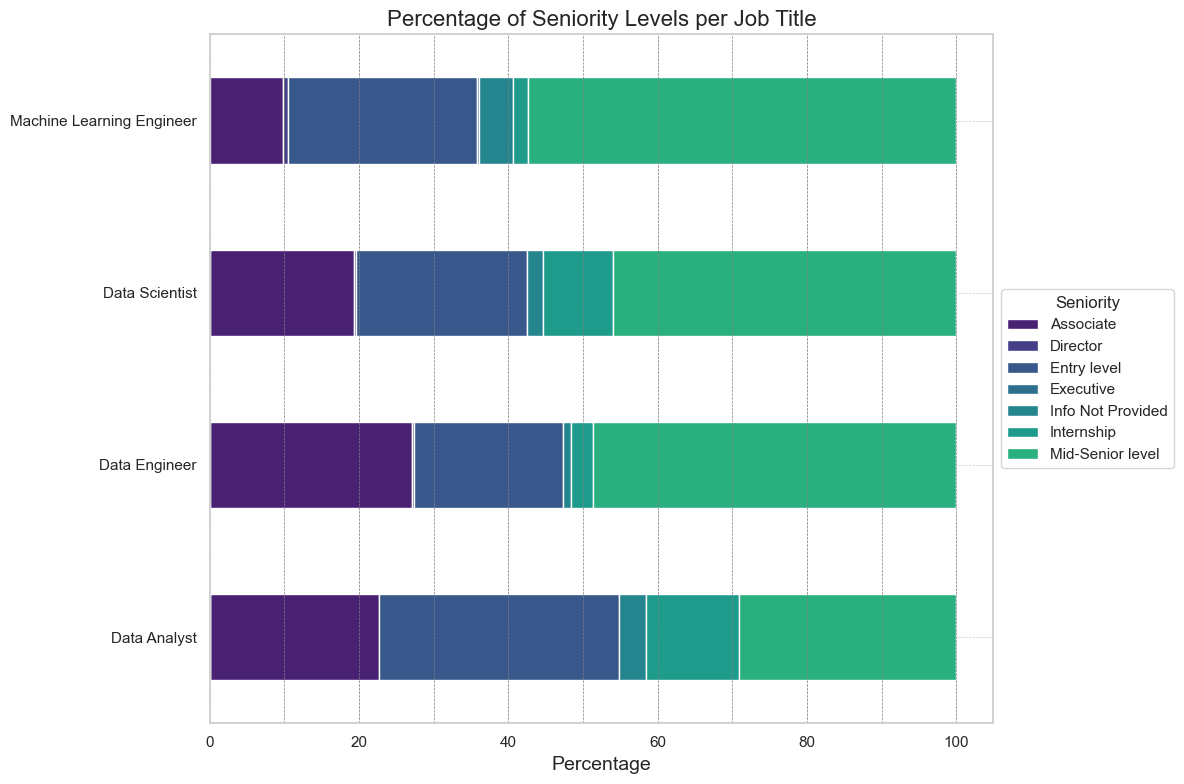

In [228]:
# Group by 'Keywords' and 'Seniority' to get the count of postings for each combination
grouped = df_combined.groupby(['Keywords', 'Seniority']).size().unstack(fill_value=0)

# Calculate the total number of postings per keyword
total_per_keyword = grouped.sum(axis=1)

# Calculate the percentage for each seniority level within each keyword
percentage_df = grouped.div(total_per_keyword, axis=0) * 100

# Plotting the percentage DataFrame using horizontal bars
fig, ax = plt.subplots(figsize=(12, 8))
percentage_df.plot(kind='barh', stacked=True, ax=ax)

# Add vertical lines at specified positions to help readability
for line in range(10, 101, 10):
    ax.axvline(line, color='gray', linestyle='--', linewidth=0.5)

# Add gridlines for better readability
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add titles and labels
ax.set_title('Percentage of Seniority Levels per Job Title', fontsize=16)
ax.set_xlabel('Percentage', fontsize=14)
ax.set_ylabel('', fontsize=14)

# Move the legend out of the plot
ax.legend(title='Seniority', loc='center left', bbox_to_anchor=(1.0, 0.5))

# Show the plot
plt.tight_layout()
plot_filename = os.path.join(plot_dir, 'Percentage of Seniority Levels per Job Title.png')
plt.savefig(plot_filename)
plt.show()

# grouped = df_combined.groupby(['Keywords', 'Seniority']).size().unstack(fill_value=0)

# # Plotting Graph
# grouped.plot(kind='bar', figsize=(12, 8))

# plt.title('Job Postings by Job Title and Seniority')
# plt.xlabel('Keywords')
# plt.ylabel('Count')
# plt.xticks(rotation=20)
# plt.legend(title='Seniority')
# plot_filename = os.path.join(plot_dir, 'Job Postings by Job Title and Seniority.png')
# plt.savefig(plot_filename)
# plt.show()


## Percentage of Job Postings by Job Title and Seniority

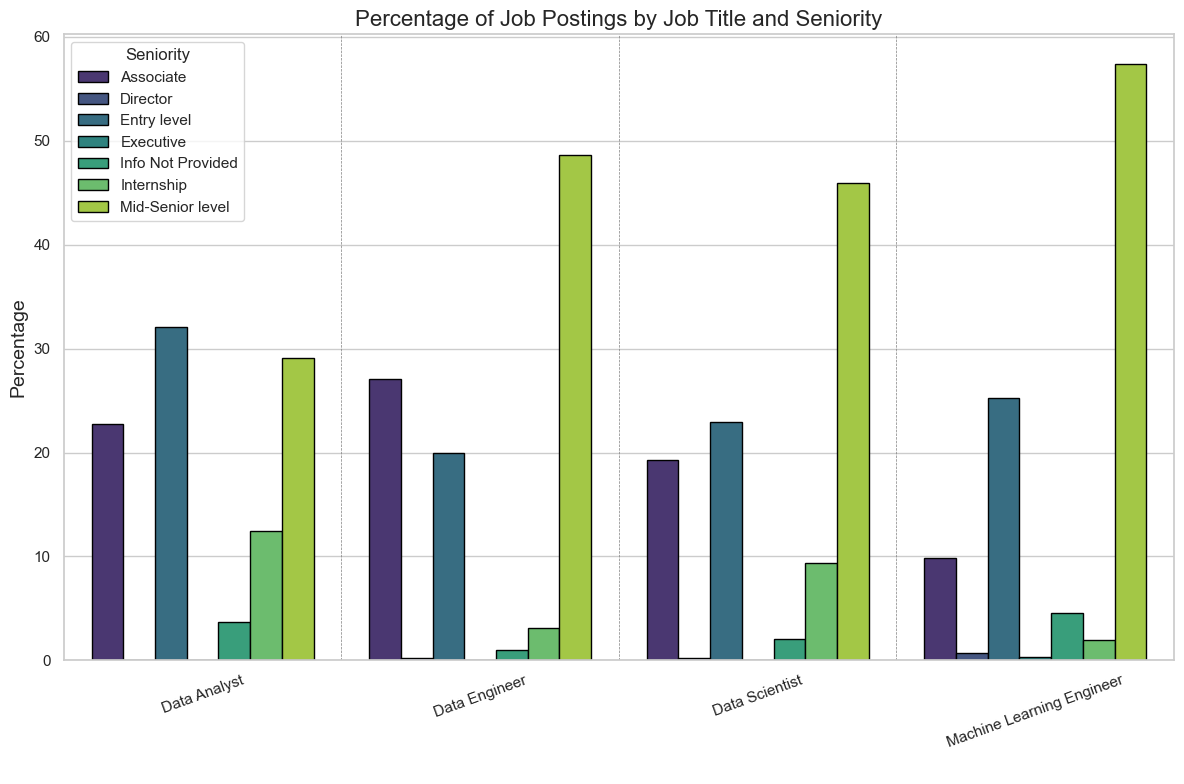

In [229]:
# Group by 'Keywords' and 'Seniority' to get the count of postings for each combination
grouped = df_combined.groupby(['Keywords', 'Seniority']).size().unstack(fill_value=0)

# Calculate the total number of postings per keyword
total_per_keyword = grouped.sum(axis=1)

# Calculate the percentage for each seniority level within each keyword
percentage_df = grouped.div(total_per_keyword, axis=0) * 100

# Reset the index for easier plotting with Seaborn
percentage_df = percentage_df.reset_index().melt(id_vars='Keywords', var_name='Seniority', value_name='Percentage')

# Plotting the percentage DataFrame using Seaborn for vertical bars
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Keywords', 
    y='Percentage', 
    hue='Seniority', 
    data=percentage_df, 
    palette='viridis',
    edgecolor='black'
)

# Add vertical lines between job roles on the x-axis
unique_keywords = percentage_df['Keywords'].unique()
for i in range(1, len(unique_keywords)):
    plt.axvline(x=i - 0.5, color='gray', linestyle='--', linewidth=0.5)

# Add titles and labels
plt.title('Percentage of Job Postings by Job Title and Seniority', fontsize=16)
plt.xlabel(' ', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.xticks(rotation=20)

# Show the plot
plt.tight_layout()
plot_filename = os.path.join(plot_dir, 'Percentage_of_Job_Postings_by_Job_Title_and_Seniority.png')
plt.savefig(plot_filename)
plt.show()


## Age of job postings 

In [230]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Define plot directory
plot_dir = 'C:\\Users\\thisi\\code\\DataCareerAnalysis\\plots'  # Update this path as needed

# Ensure 'Collected Date' and 'Posted' are in datetime format
df_combined.loc[:, 'Collected Date'] = pd.to_datetime(df_combined['Collected Date'])
df_combined.loc[:, 'Posted'] = pd.to_datetime(df_combined['Posted'])

# Calculate job age in days
df_combined.loc[:, 'Job Age'] = (df_combined['Collected Date'] - df_combined['Posted']).dt.days

# Calculate the average job age
average_job_age = df_combined['Job Age'].mean()
print(f'The average age of the jobs is {average_job_age:.2f} days.')

# Plotting the histogram using Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(df_combined['Job Age'], bins=10, kde=False, edgecolor='black', color='teal')
plt.title('Histogram of how long the Job postings have been up', fontsize=16)
plt.xlabel('Job Age (days)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
plt.tight_layout()

# Save the histogram plot
histogram_filename = os.path.join(plot_dir, 'Average_Posting_Age_Histogram.png')
plt.savefig(histogram_filename)
plt.show()

# Group by Keywords and calculate the average job age for each keyword
average_job_age_per_keyword = df_combined.groupby('Keywords')['Job Age'].mean().reset_index()

# Plotting the bar chart using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Keywords', y='Job Age', data=average_job_age_per_keyword, palette='viridis', edgecolor='black', hue='Keywords', dodge=False, legend=False)
plt.title('Average Posting Age by Position', fontsize=16)
plt.xlabel('Position (Keyword)', fontsize=14)
plt.ylabel('Average Job Age (days)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout()

# Save the bar plot
bar_plot_filename = os.path.join(plot_dir, 'Average_Posting_Age_by_Position.png')
plt.savefig(bar_plot_filename)
plt.show()


AttributeError: Can only use .dt accessor with datetimelike values

## Job Description Analysis 

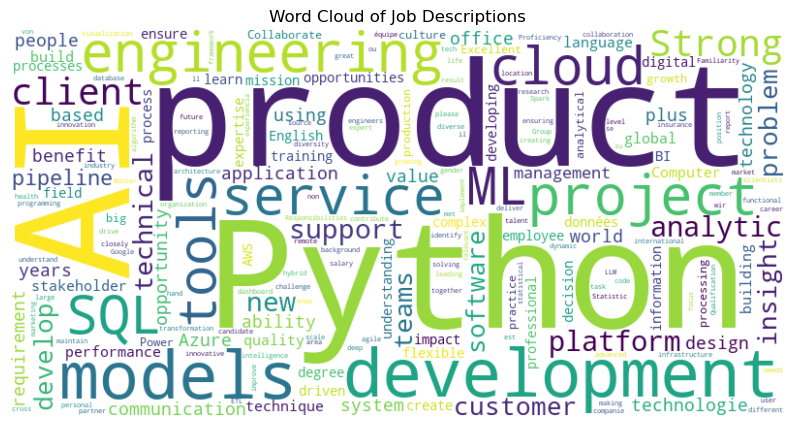

In [ ]:
#Wordcloud of full dataset 
# Combine all job descriptions into a single text
text = ' '.join(df_combined['Job Description'].dropna().tolist())

# Define custom stopwords
custom_stopwords = set(STOPWORDS)
custom_stopwords.update([
    'fast', 'way', 'set', 'related', 'full', 'net', 'across', 'best', 'datos', 'high', 'days', 'een', 'time',
    'Analyst', 'Engineer', 'Scientist', 'about', 'the', 'job', 'team', 'machine', 'learning', 'data', 'experience',
    'various', 'including', 'every', 'looking', 'sur', 'join', 'work', 'des', 'apply', 'provide', 'help', 'offer', 'analysis', 'skill', 'skills', 'business', 'science', 'solution',
    'working', 'role', 'tool', 'environment', 'company', 'role', 'year', 'knowledge', 
    'real', 'dans', 'donnée', 'day', 'want', 'may', 's', 'avec', 'die', 'within', 'take', 're', 'dato', 'mit', 'end',
    'part', 'van', 'los', 'may', 'key', 'una', 'au', 'ait', 'para', 'del', 'nous', 'pour', 'der', 're', 'die', 'la',
    'que', 'und', 'y', 'will', 'les', 'e', 'de', 'un', 'en', 'con', 'u', 'une', 'le', 'one', 'a', 'best offer', 'et',
    'etc', 'nos', 'je', 'o', 'di', 'te', 'd', 'well', 'good', 'need', 'make', 'dan', 'l', 'el', 'Vous', 'use', 'use',
    'and', 'du', 'à', 'al', 'lo', 'tu', 'us', 'per', 'g', 'home', 'notre', 'model' , 'solutions'
])
# Generate the word cloud
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    colormap='viridis', 
    collocations=False, 
    stopwords=custom_stopwords
).generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.title('Word Cloud of Job Descriptions')
plot_filename = os.path.join(plot_dir, 'Word Cloud of Job Descriptions.png')
plt.savefig(plot_filename)
plt.show()

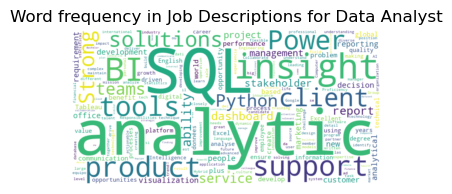

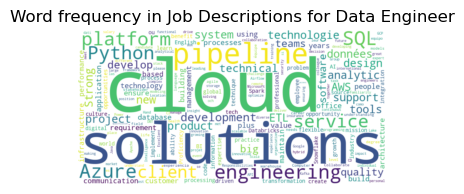

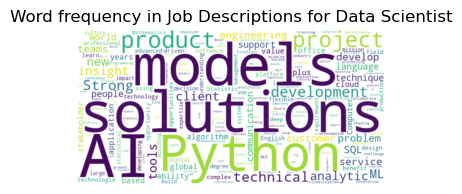

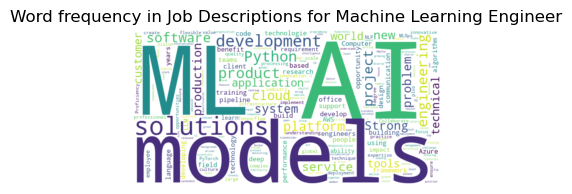

In [ ]:
#Word Clouds from job description for each Job title
# Define custom stopwords
custom_stopwords = set(STOPWORDS)
custom_stopwords.update([
    'fast', 'way', 'set', 'related', 'full', 'net', 'across', 'best', 'datos', 'high', 'days', 'een', 'time',
    'Analyst', 'Engineer', 'Scientist', 'about', 'the', 'job', 'team', 'machine', 'learning', 'data', 'experience',
    'various', 'including', 'every', 'looking', 'sur', 'join', 'work', 'des', 'apply', 'provide', 'help', 'offer', 'analysis', 'skill', 'skills', 'business', 'science', 'solution',
    'working', 'role', 'tool', 'environment', 'company', 'role', 'year', 'knowledge', 
    'real', 'dans', 'donnée', 'day', 'want', 'may', 's', 'avec', 'die', 'within', 'take', 're', 'dato', 'mit', 'end',
    'part', 'van', 'los', 'may', 'key', 'una', 'au', 'ait', 'para', 'del', 'nous', 'pour', 'der', 're', 'die', 'la',
    'que', 'und', 'y', 'will', 'les', 'e', 'de', 'un', 'en', 'con', 'u', 'une', 'le', 'one', 'a', 'best offer', 'et',
    'etc', 'nos', 'je', 'o', 'di', 'te', 'd', 'well', 'good', 'need', 'make', 'dan', 'l', 'el', 'Vous', 'use', 'use',
    'and', 'du', 'à', 'al', 'lo', 'tu', 'us', 'per', 'g', 'home', 'notre', 'model'
])

# Loop through each unique keyword
unique_keywords = df_combined['Keywords'].unique()

for keyword in unique_keywords:
    # Filter job descriptions for the current keyword
    keyword_descriptions = df_combined[df_combined['Keywords'] == keyword]['Job Description'].dropna().tolist()
    text = ' '.join(keyword_descriptions)

    # Generate the word cloud
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white', 
        colormap='viridis', 
        collocations=False, 
        stopwords=custom_stopwords
    ).generate(text)

    # Display the word cloud using matplotlib
    plt.figure(figsize=(6, 2))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Hide the axes
    plt.title(f'Word frequency in Job Descriptions for {keyword}')
    plot_filename = os.path.join(plot_dir, f'Word frequency in Job Descriptions for {keyword}.png')
    plt.savefig(plot_filename)
    plt.show()

## Tools and Languages most mentioned in job postings 

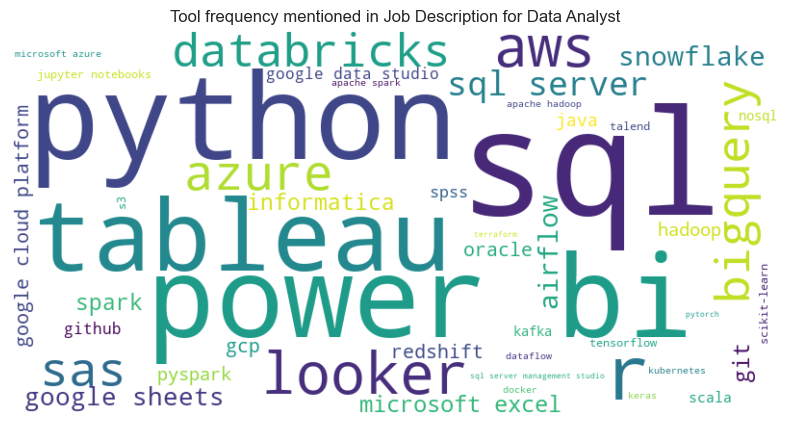

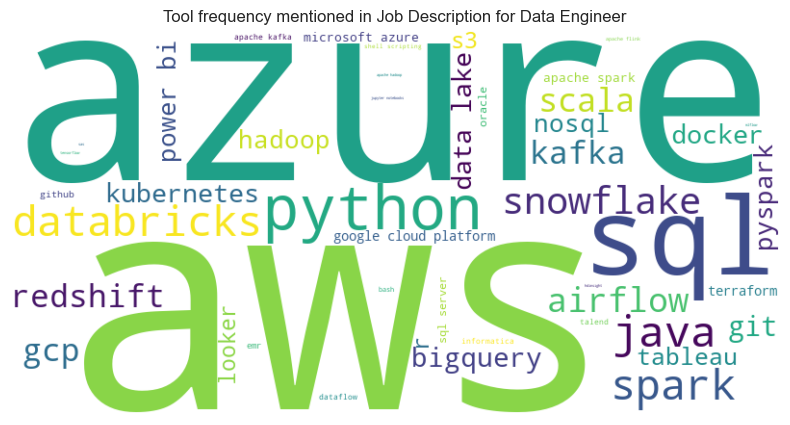

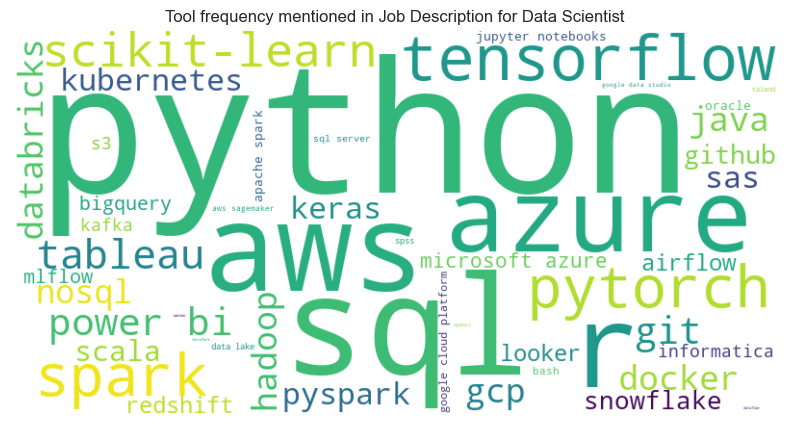

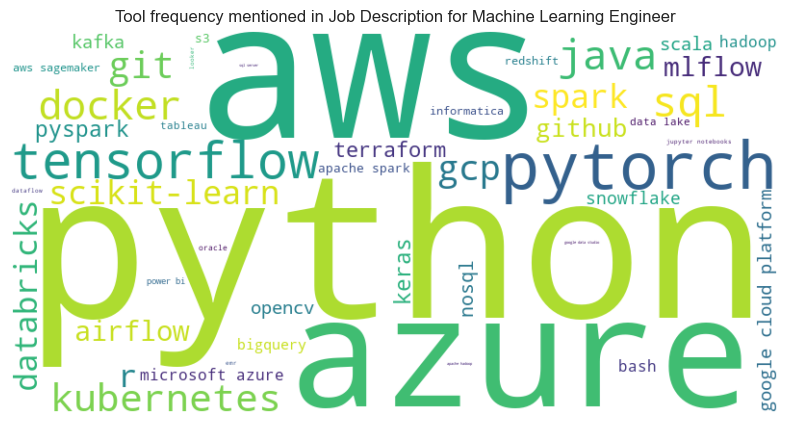

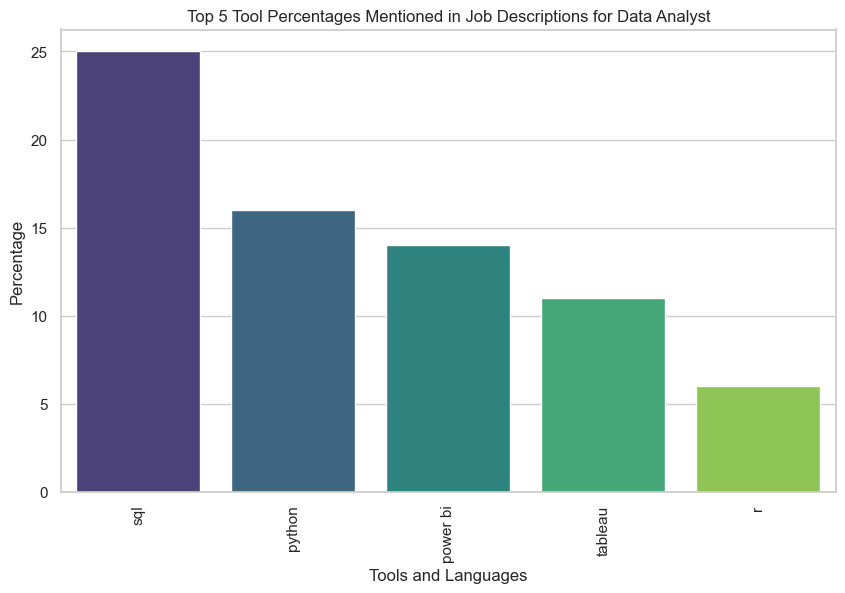

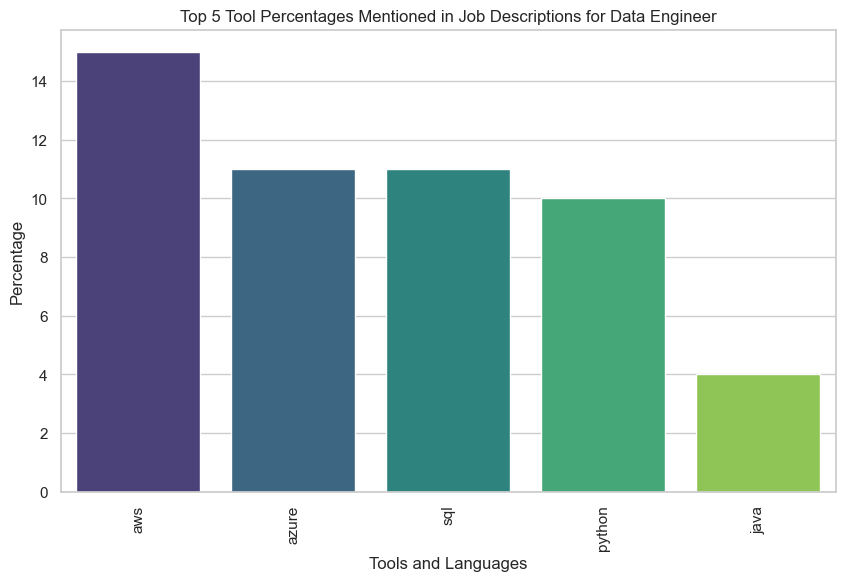

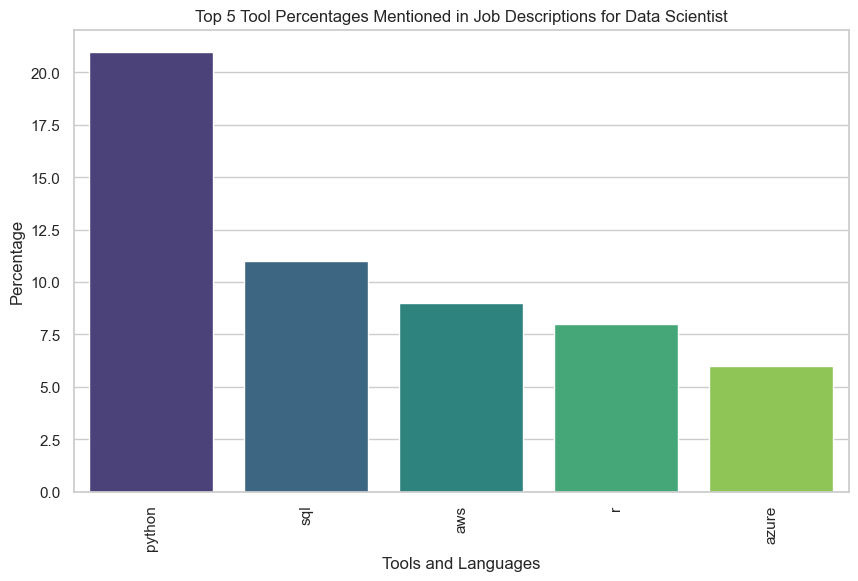

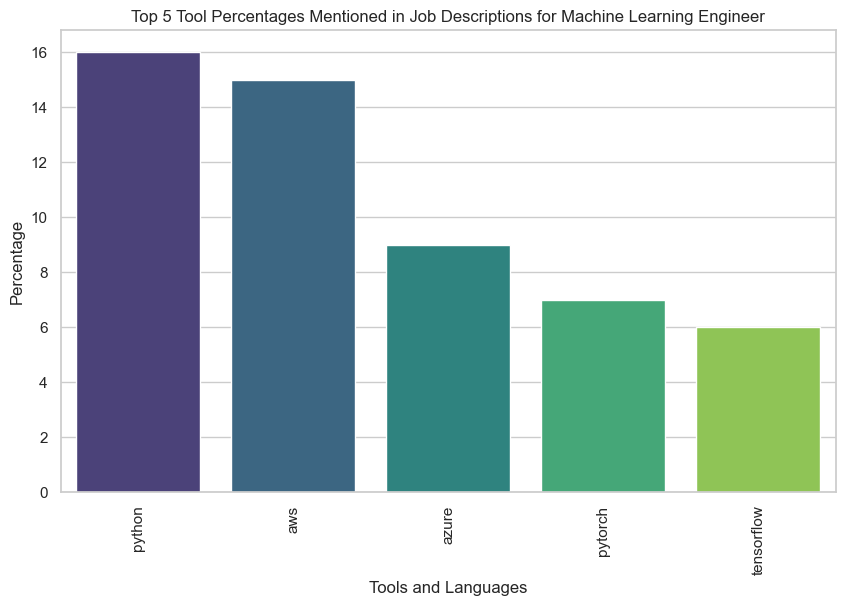

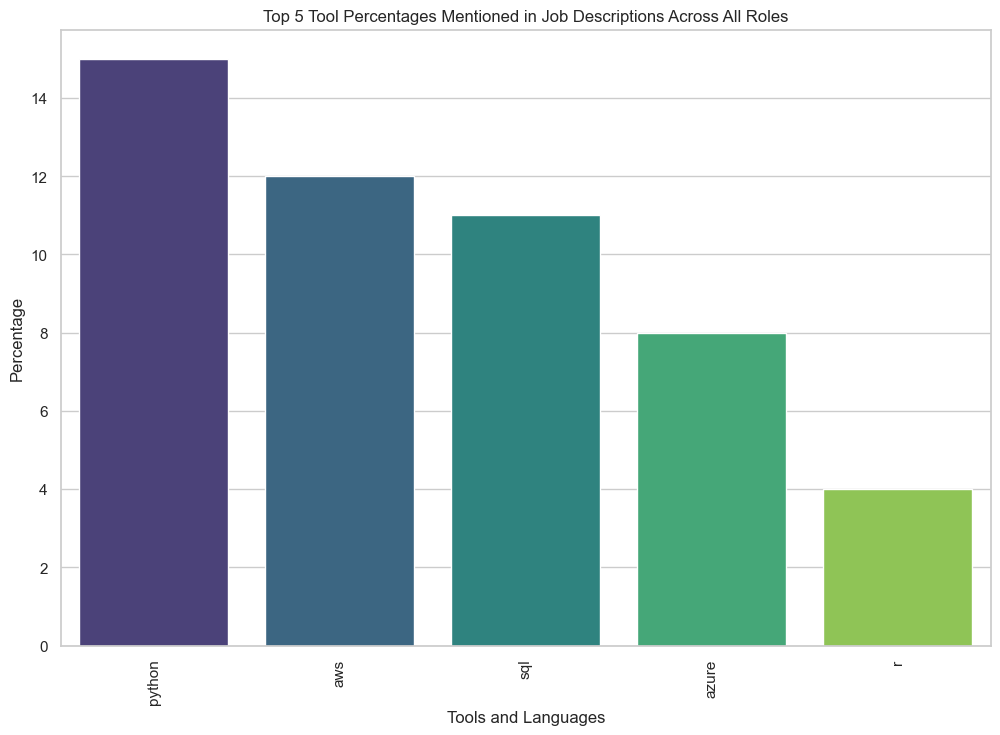

In [ ]:
# List of tools and programming languages for all roles
tools_and_languages = [
    'Microsoft Excel', 'Google Sheets', 'Tableau', 'Power BI', 'Looker', 'SAS', 'SPSS', 'SQL', 'Python', 'R',
    'Jupyter Notebooks', 'Google Data Studio', 'MySQL Workbench', 'SQL Server Management Studio',
    'RStudio', 'Apache Hadoop', 'Apache Spark', 'TensorFlow', 'PyTorch', 'Scikit-learn', 'IBM Watson',
    'Scala', 'Git', 'GitHub', 'Docker', 'Kubernetes', 'Apache Kafka', 'Airflow',
    'Apache Flink', 'AWS', 'Redshift', 'S3', 'EMR', 'Google Cloud Platform', 'BigQuery', 'Dataflow',
    'Microsoft Azure', 'Data Lake', 'HDInsight', 'Databricks', 'Snowflake', 'Talend', 'Informatica',
    'Java', 'Bash', 'Shell scripting', 'Terraform',
    'Keras', 'OpenCV', 'MLflow', 'Google AI Platform', 'AWS SageMaker', 'Microsoft Azure ML',
    'C++', 'Azure', 'Redshift', 'Oracle', 'Spark', 'Java', 'Hadoop', 'Kafka', 'AWS', 'NoSql', 'Watson', 'GCP', 'SQL Server',
    'PySpark'
]

# Convert all tools and languages to lowercase for case-insensitive matching
tools_and_languages = [tool.lower() for tool in tools_and_languages]

# Define custom stopwords
custom_stopwords = set(STOPWORDS)
custom_stopwords.update([
    'fast', 'way', 'set', 'related', 'full', 'net', 'across', 'best', 'datos', 'high', 'days', 'een', 'time',
    'Analyst', 'Engineer', 'Scientist', 'about', 'the', 'job', 'team', 'machine', 'learning', 'data', 'experience',
    'various', 'including', 'every', 'looking', 'sur', 'join', 'work', 'des', 'apply', 'provide', 'help', 'offer', 'analysis', 'skill', 'skills', 'business', 'science', 'solution',
    'working', 'role', 'tool', 'environment', 'company', 'role', 'year', 'knowledge', 
    'real', 'dans', 'donnée', 'day', 'want', 'may', 's', 'avec', 'die', 'within', 'take', 're', 'dato', 'mit', 'end',
    'part', 'van', 'los', 'may', 'key', 'una', 'au', 'ait', 'para', 'del', 'nous', 'pour', 'der', 're', 'die', 'la',
    'que', 'und', 'y', 'will', 'les', 'e', 'de', 'un', 'en', 'con', 'u', 'une', 'le', 'one', 'a', 'best offer', 'et',
    'etc', 'nos', 'je', 'o', 'di', 'te', 'd', 'well', 'good', 'need', 'make', 'dan', 'l', 'el', 'Vous', 'use', 'use',
    'and', 'du', 'à', 'al', 'lo', 'tu', 'us', 'per', 'g', 'home', 'notre', 'model'
])

# Function to count occurrences of tools and languages in job descriptions
def count_tools_and_languages(job_description, tools_and_languages, tool_counts):
    job_description = job_description.lower()
    for tool in tools_and_languages:
        # Use regular expressions to count whole words
        pattern = r'\b' + re.escape(tool) + r'\b'
        tool_counts[tool] += len(re.findall(pattern, job_description))
    return tool_counts

# Initialize a dictionary to store the counts for each role
role_tool_counts = {role: {tool: 0 for tool in tools_and_languages} for role in df_combined['Keywords'].unique()}

# Loop through each unique keyword (role)
for keyword in df_combined['Keywords'].unique():
    # Initialize a dictionary to hold counts of each tool/language for the current role
    tool_counts = {tool: 0 for tool in tools_and_languages}

    # Filter job descriptions for the current keyword (role)
    keyword_descriptions = df_combined[df_combined['Keywords'] == keyword]['Job Description'].dropna().tolist()
    for job_description in keyword_descriptions:
        tool_counts = count_tools_and_languages(job_description, tools_and_languages, tool_counts)

    # Store the counts in the role_tool_counts dictionary
    role_tool_counts[keyword] = tool_counts

    # Filter out tools/languages that were not found
    filtered_tool_counts = {k: v for k, v in tool_counts.items() if v > 0}

    # Generate a word cloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=custom_stopwords
    ).generate_from_frequencies(filtered_tool_counts)

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Hide the axes
    plt.title(f'Tool frequency mentioned in Job Description for {keyword}')
    plot_filename = os.path.join(plot_dir, f'Tool_frequency_mentioned_in_Job_Description_for_{keyword}.png')
    plt.savefig(plot_filename)
    plt.show()

# Convert the role_tool_counts dictionary to a DataFrame for easier plotting
role_tool_counts_df = pd.DataFrame(role_tool_counts).fillna(0)

# Convert counts to percentages and round to whole numbers
for role in role_tool_counts_df.columns:
    role_tool_counts_df[role] = (role_tool_counts_df[role] / role_tool_counts_df[role].sum() * 100).round().astype(int)

# Plotting the percentages for each role using Seaborn
for role in role_tool_counts_df.columns:
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=role_tool_counts_df[role].sort_values(ascending=False).head(5).index, 
        y=role_tool_counts_df[role].sort_values(ascending=False).head(5).values,
        hue=role_tool_counts_df[role].sort_values(ascending=False).head(5).index,
        palette='viridis',
        dodge=False,
        legend=False
    )
    plt.title(f'Top 5 Tool Percentages Mentioned in Job Descriptions for {role}')
    plt.xlabel('Tools and Languages')
    plt.ylabel('Percentage')
    plt.xticks(rotation=90)
    plot_filename = os.path.join(plot_dir, f'Top_5_Percentages_Mentioned_in_Job_Descriptions_for_{role}.png')
    plt.savefig(plot_filename)
    plt.show()

# Aggregate percentages across all roles
total_tool_counts = {tool: 0 for tool in tools_and_languages}
for role in role_tool_counts:
    for tool in role_tool_counts[role]:
        total_tool_counts[tool] += role_tool_counts[role][tool]

# Filter out tools/languages that were not found
filtered_total_tool_counts = {k: v for k, v in total_tool_counts.items() if v > 0}

# Convert to DataFrame for easier manipulation
total_tool_counts_df = pd.DataFrame(list(filtered_total_tool_counts.items()), columns=['Tool', 'Count'])
total_tool_counts_df['Percentage'] = (total_tool_counts_df['Count'] / total_tool_counts_df['Count'].sum() * 100).round().astype(int)
total_tool_counts_df = total_tool_counts_df.sort_values(by='Percentage', ascending=False).head(5)

# Plotting the top 5 tools across all roles using Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Tool', 
    y='Percentage', 
    hue='Tool',
    data=total_tool_counts_df, 
    palette='viridis',
    dodge=False,
    legend=False
)
plt.title('Top 5 Tool Percentages Mentioned in Job Descriptions Across All Roles')
plt.xlabel('Tools and Languages')
plt.ylabel('Percentage')
plt.xticks(rotation=90)
plot_filename = os.path.join(plot_dir, 'Top_5_Tool_Percentages_Mentioned_in_Job_Descriptions_Across_All_Roles.png')
plt.savefig(plot_filename)
plt.show()


## Heatmap of Desired Education Levels by Data Role

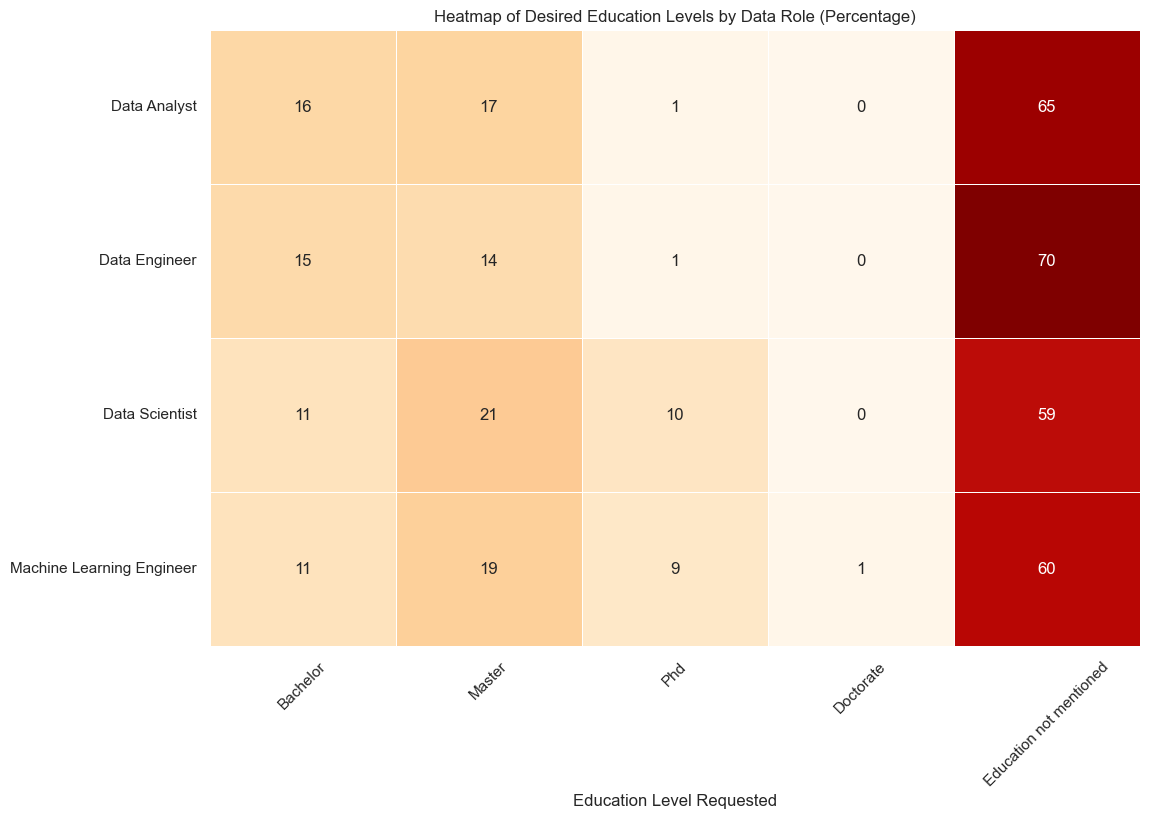

In [ ]:
# Set the Seaborn theme to 'white' for a clean heatmap display
sns.set_theme(style="white")

# List of education levels to check in job descriptions
education_levels = ['bachelor', 'master', 'phd', 'doctorate']

# Convert all education levels to lowercase for case-insensitive matching
education_levels = [level.lower() for level in education_levels]

# Function to count occurrences of education levels in job descriptions
def count_education_levels(job_description, education_levels):
    job_description = job_description.lower()
    education_counts = {level: 0 for level in education_levels}
    for level in education_levels:
        pattern = r'\b' + re.escape(level) + r'\b'
        education_counts[level] = len(re.findall(pattern, job_description))
    # Check if none of the education levels are mentioned
    if all(count == 0 for count in education_counts.values()):
        education_counts['Education not mentioned'] = 1
    else:
        education_counts['Education not mentioned'] = 0
    return education_counts

# Initialize a list to store the counts for each role
role_education_counts_list = []

# Process each job description
for index, row in df_combined.iterrows():
    role = row['Keywords']
    job_description = row['Job Description']
    
    # Count education levels in the job description
    education_counts = count_education_levels(job_description, education_levels)
    
    # Add the counts to the list
    education_counts['role'] = role
    role_education_counts_list.append(education_counts)

# Convert the list to a DataFrame
role_education_counts = pd.DataFrame(role_education_counts_list)

# Aggregate counts by role
role_education_counts = role_education_counts.groupby('role').sum().reset_index()

# Convert counts to percentages
role_education_counts.set_index('role', inplace=True)
role_education_counts_percentage = role_education_counts.div(role_education_counts.sum(axis=1), axis=0) * 100
role_education_counts_percentage = role_education_counts_percentage.round().astype(int)  # Convert to whole numbers

# Plot heatmap using Seaborn with the 'magma' color palette
plt.figure(figsize=(12, 8))
cmap = sns.color_palette("OrRd", as_cmap=True)

# Draw the heatmap with annotations
ax = sns.heatmap(role_education_counts_percentage, annot=True, fmt='d', cmap=cmap, linewidths=0.5, cbar=False)

plt.title('Heatmap of Desired Education Levels by Data Role (Percentage)')
plt.xlabel('Education Level Requested')
ax.set_ylabel('')

plt.xticks(rotation=45)

# Capitalize x-axis labels
current_labels = [label.get_text() for label in ax.get_xticklabels()]
capitalized_labels = [label.capitalize() for label in current_labels]
ax.set_xticklabels(capitalized_labels)

plt.yticks(rotation=0)
plot_filename = os.path.join(plot_dir, 'Heatmap_of_Desired_Education_Levels_by_Data_Role_Percentage.png')
plt.savefig(plot_filename)
plt.show()


## Grouped visulisation of Job Postings Age

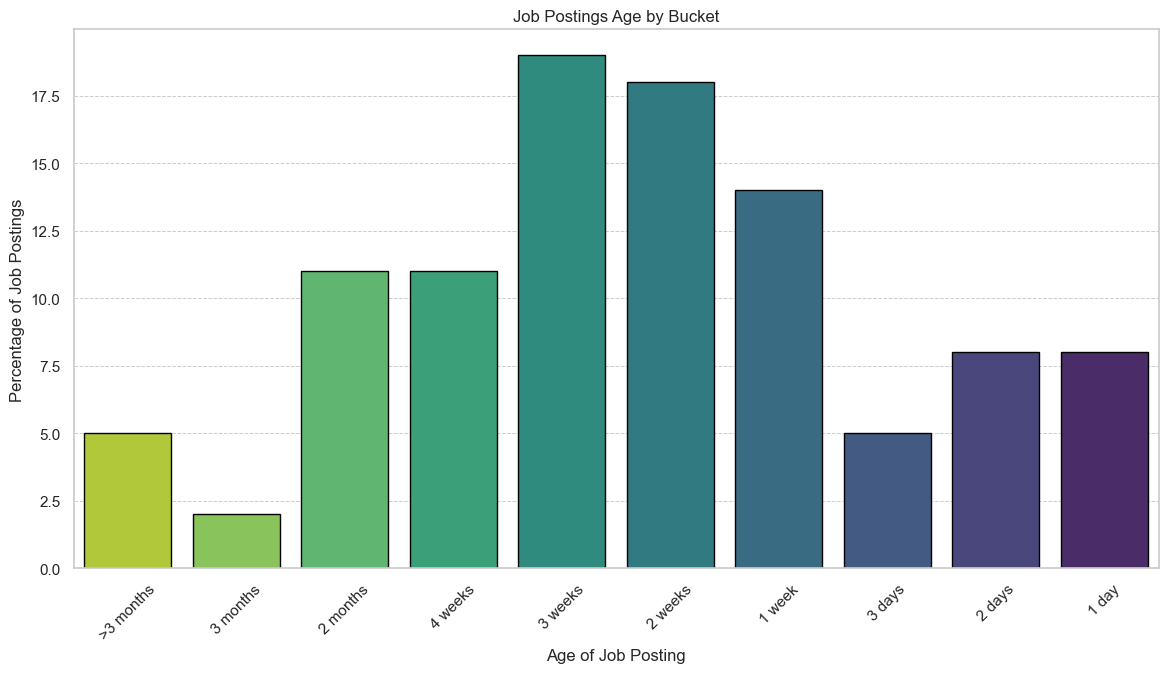

In [ ]:
# Calculate the age of each job posting in days relative to the 'Collected Date'
df_combined.loc[:, 'Days Ago'] = (df_combined['Collected Date'] - df_combined['Posted']).dt.days

# Define the buckets based on LinkedIn's increments
bins = [0, 1, 2, 3, 7, 14, 21, 28, 60, 90, np.inf]
labels = ['1 day', '2 days', '3 days', '1 week', '2 weeks', '3 weeks', '4 weeks', '2 months', '3 months', '>3 months']

# Categorize the postings into these buckets
df_combined.loc[:, 'Bucket'] = pd.cut(df_combined['Days Ago'], bins=bins, labels=labels, right=False)

# Count the frequency of job postings in each bucket and calculate percentages
bucket_counts = df_combined['Bucket'].value_counts(normalize=True).reindex(labels, fill_value=0).reset_index()
bucket_counts.columns = ['Bucket', 'Percentage']
bucket_counts['Percentage'] = (bucket_counts['Percentage'] * 100).round().astype(int)  # Convert to whole number percentages

# Plotting the data using Seaborn
plt.figure(figsize=(14, 7))
sns.barplot(
    x='Bucket', 
    y='Percentage', 
    hue='Bucket',
    data=bucket_counts, 
    palette='viridis', 
    edgecolor='black',
    dodge=False,
    legend=False
)
plt.title('Job Postings Age by Bucket')
plt.xlabel('Age of Job Posting')
plt.ylabel('Percentage of Job Postings')
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.xticks(rotation=45)
plt.gca().invert_xaxis()  # Reverse the order of the x-axis to match visual above

# Save the plot
plot_filename = os.path.join(plot_dir, 'Job_Postings_Age_by_Bucket.png')
plt.savefig(plot_filename)
plt.show()


## Posting patterns over the last 30 days

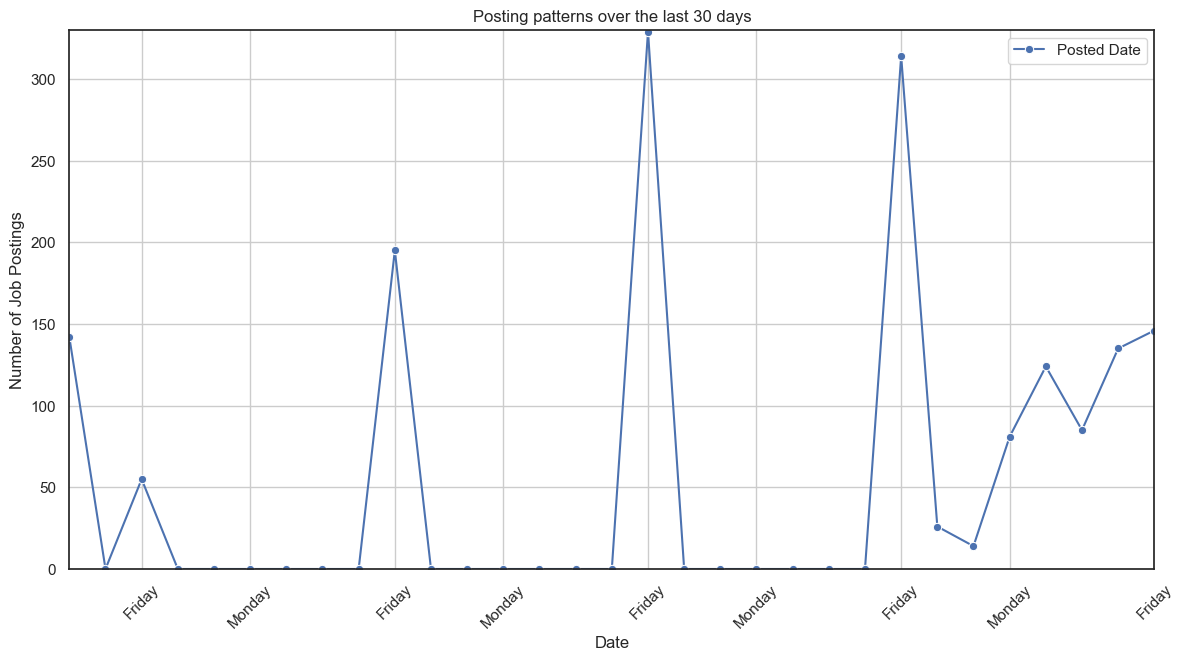

In [ ]:
# Determine the latest date in the 'Posted' column
latest_date = df_combined['Posted'].max()

# Calculate the date 30 days before the latest date
x_days_ago = latest_date - pd.DateOffset(days=30)

# Filter the data for the last 30 days
filtered_df = df_combined[df_combined['Posted'] >= x_days_ago].copy()

# Check if filtered_df is empty
if filtered_df.empty:
    print("No data available for the last 30 days.")
else:
    # Remove the time component for accurate resampling
    filtered_df.loc[:, 'Posted'] = filtered_df['Posted'].dt.normalize()

    # Resample the data to count the number of job postings per day
    posted_count = filtered_df.set_index('Posted').resample('D').size()

    # Create a date range for the last 30 days to ensure all days are included
    date_range = pd.date_range(start=x_days_ago, end=latest_date, freq='D')

    # Reindex the counts to ensure they match the date range and fill missing values with 0
    posted_count = posted_count.reindex(date_range, fill_value=0)

    # Add a column for day names
    posted_count.index = posted_count.index.to_series()
    posted_count.index.name = 'Date'
    posted_count = posted_count.reset_index()
    posted_count['Day'] = posted_count['Date'].dt.day_name()

    # Filter for Mondays and Fridays only for x-ticks
    xticks = posted_count[posted_count['Date'].dt.dayofweek.isin([0, 4])]

    # Plotting the time series with Seaborn
    plt.figure(figsize=(14, 7))
    sns.lineplot(x='Date', y=0, data=posted_count, marker='o', label='Posted Date')
    plt.title('Posting patterns over the last 30 days')
    plt.xlabel('Date')
    plt.ylabel('Number of Job Postings')
    plt.legend()
    plt.grid(True)
    plt.xlim([x_days_ago, latest_date])
    plt.ylim(0, posted_count[0].max() + 1)  # Adding 1 to ensure the highest point is visible
    plt.xticks(ticks=xticks['Date'], labels=xticks['Day'], rotation=45)
    plt.show()


## Distribution of Employees with Mean, Median, and Mode

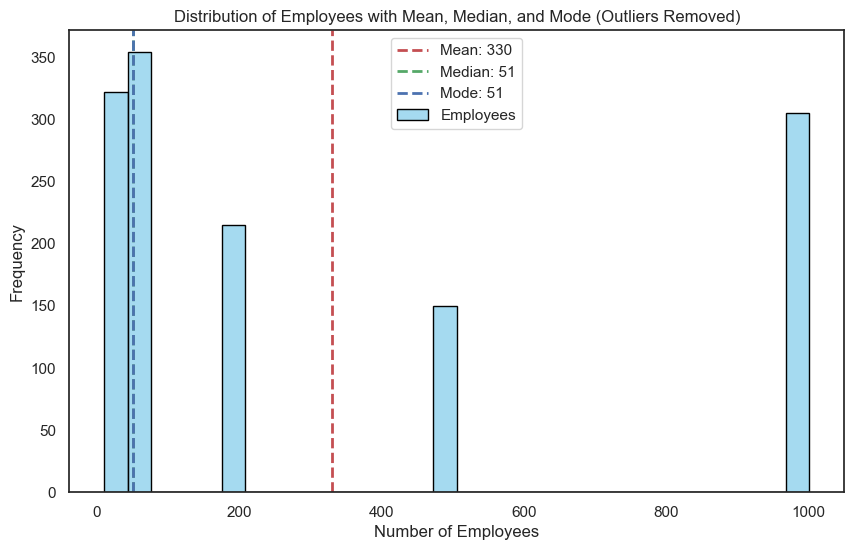

In [ ]:
# Filter out outliers with 0 employees and over 4000 employees
df_combined = df_combined[(df_combined['Employees'] > 9) & (df_combined['Employees'] < 4000)]

# Recalculate mean, median, and mode after removing outliers
mean_employees = df_combined['Employees'].mean()
median_employees = df_combined['Employees'].median()
mode_employees = df_combined['Employees'].mode()[0]

# Plotting the mean, median, and mode after removing outliers using Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(df_combined['Employees'], bins=30, kde=False, color='skyblue', label='Employees', edgecolor='black')

# Adding vertical lines for mean, median, and mode
plt.axvline(mean_employees, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {int(mean_employees)}')
plt.axvline(median_employees, color='g', linestyle='dashed', linewidth=2, label=f'Median: {int(median_employees)}')
plt.axvline(mode_employees, color='b', linestyle='dashed', linewidth=2, label=f'Mode: {int(mode_employees)}')

# Customizing the plot
plt.legend()
plt.xlabel('Number of Employees')
plt.ylabel('Frequency')
plt.title('Distribution of Employees with Mean, Median, and Mode (Outliers Removed)')
plt.show()


## Distribution of Applicants with Mean, Median, and Mode

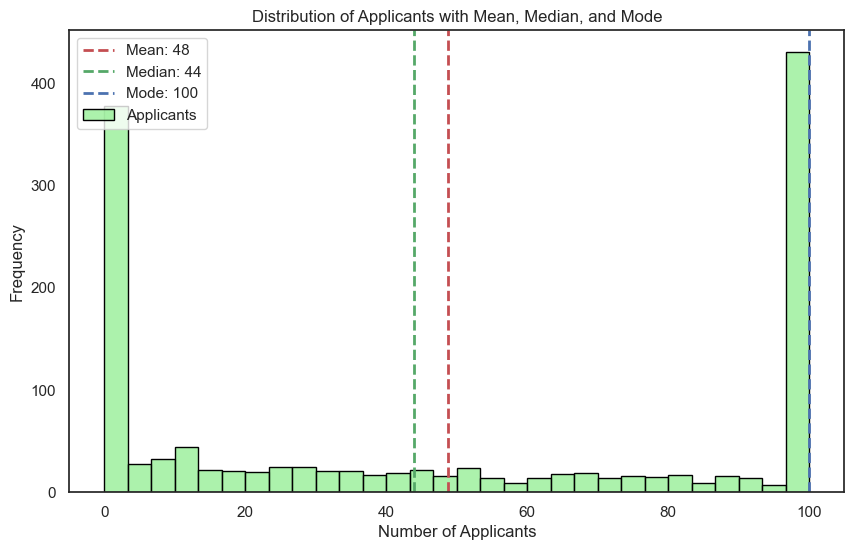

In [ ]:
# MMM of Distribution of Applicants
# Recalculate mean, median, and mode for 'Applicants'
mean_applicants = df_combined['Applicants'].mean()
median_applicants = df_combined['Applicants'].median()
mode_applicants = df_combined['Applicants'].mode()[0]

# Plotting the mean, median, and mode for 'Applicants' using Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(df_combined['Applicants'], bins=30, kde=False, color='lightgreen', label='Applicants', edgecolor='black')

# Adding vertical lines for mean, median, and mode
plt.axvline(mean_applicants, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {int(mean_applicants)}')
plt.axvline(median_applicants, color='g', linestyle='dashed', linewidth=2, label=f'Median: {int(median_applicants)}')
plt.axvline(mode_applicants, color='b', linestyle='dashed', linewidth=2, label=f'Mode: {int(mode_applicants)}')

# Customizing the plot
plt.legend()
plt.xlabel('Number of Applicants')
plt.ylabel('Frequency')
plt.title('Distribution of Applicants with Mean, Median, and Mode')

# Save the plot
plot_filename = os.path.join(plot_dir, 'Distribution_of_Applicants_with_Mean_Median_and_Mode.png')
plt.savefig(plot_filename)
plt.show()


## Distribution of Applicants for Each Role


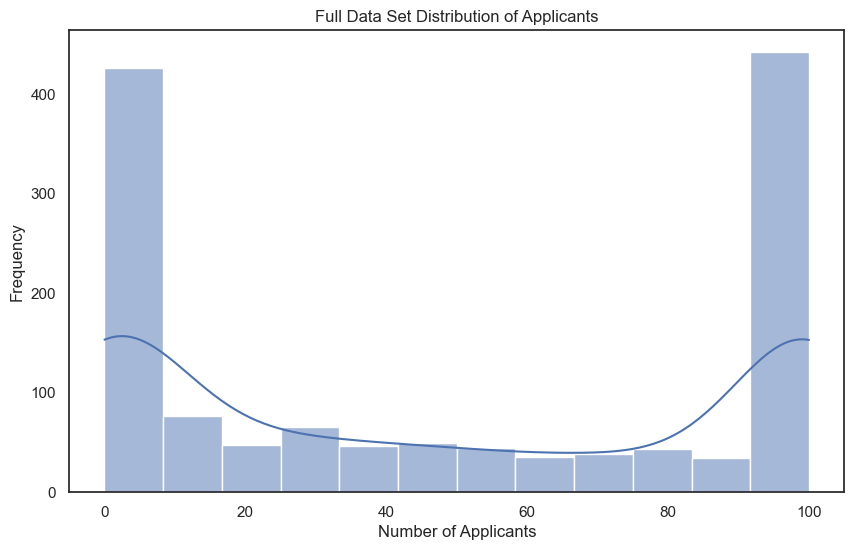

c:\Users\thisi\anaconda3\envs\DataCareerAnalysis\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1400x800 with 0 Axes>

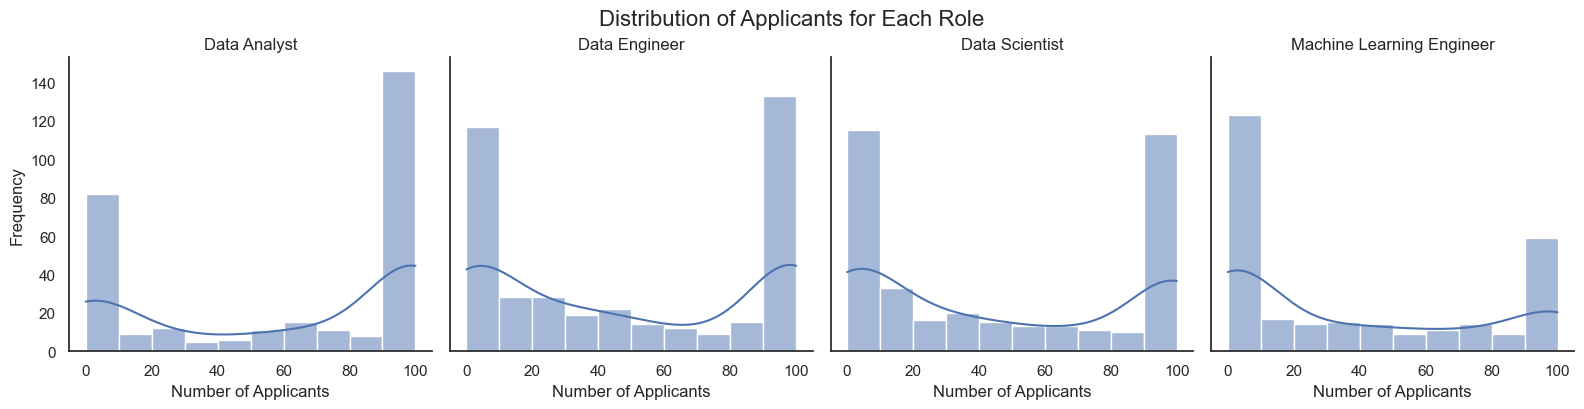

In [ ]:
# Define plot directory
plot_dir = 'C:\\Users\\thisi\\code\\DataCareerAnalysis\\plots'  # Update this path as needed

# Plot the distribution of the 'Applicants' column
plt.figure(figsize=(10, 6))
sns.histplot(df_combined['Applicants'], kde=True)  # Removed palette parameter
plt.title('Full Data Set Distribution of Applicants')
plt.xlabel('Number of Applicants')
plt.ylabel('Frequency')

# Save and show the plot
plot_filename = os.path.join(plot_dir, 'Full Data Set Distribution of Applicants.png')
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
plt.savefig(plot_filename)
plt.show()

# Plot the distribution of 'Applicants' for each role in 'Keywords'
plt.figure(figsize=(14, 8))
g = sns.FacetGrid(df_combined, col="Keywords", col_wrap=4, height=4)
g.map(sns.histplot, "Applicants", kde=True)

# Titles and labels
g.set_axis_labels('Number of Applicants', 'Frequency')
g.set_titles('{col_name}')
plt.subplots_adjust(top=0.9)  
g.fig.suptitle('Distribution of Applicants for Each Role', fontsize=16, y=1.02)  

# Save and show the plot
plot_filename = os.path.join(plot_dir, 'Distribution of Applicants for Each Role.png')
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
plt.savefig(plot_filename)
plt.show()



### Mean Number of Applicants for Each Role by Seniority of offered position


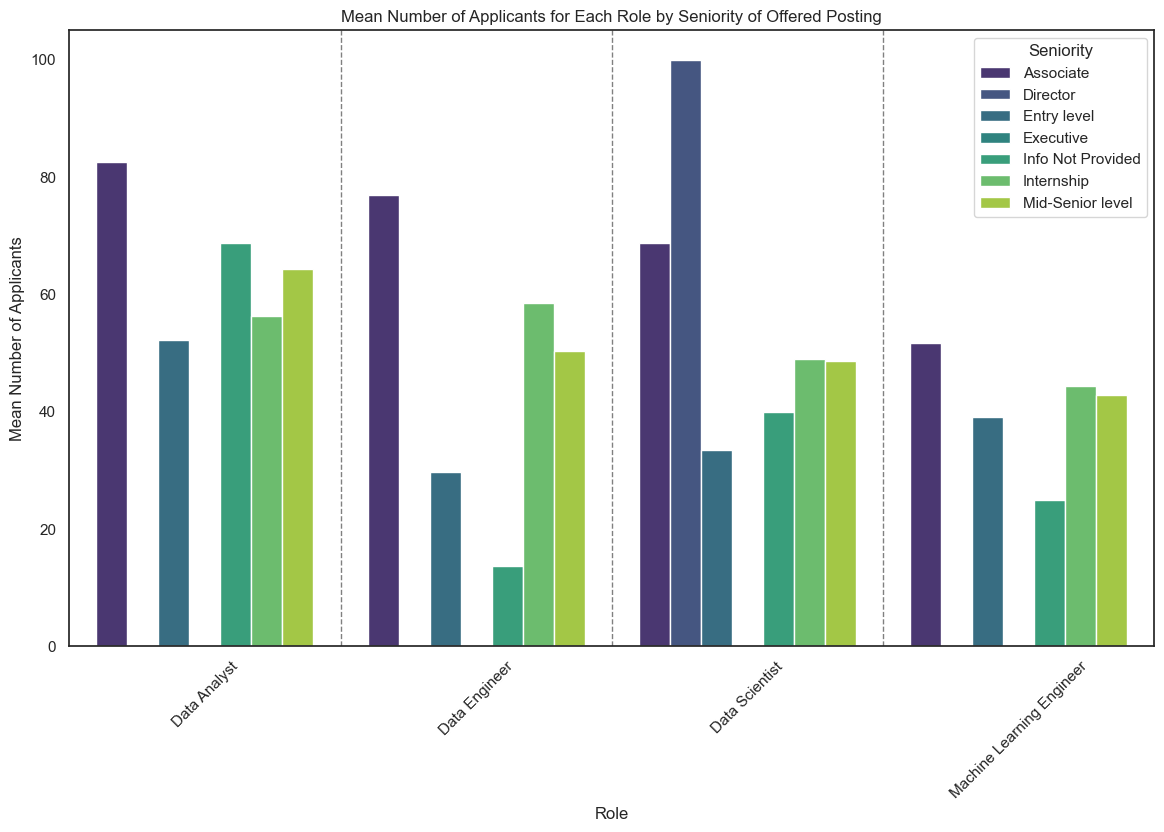

In [ ]:
# Compute the mean number of applicants for each role and seniority level
mean_counts = df_combined.groupby(['Keywords', 'Seniority'])['Applicants'].mean().unstack(fill_value=0).reset_index()

# Melt the DataFrame for seaborn
mean_counts_melted = mean_counts.melt(id_vars='Keywords', var_name='Seniority', value_name='Mean Applicants')

# Plotting using seaborn
plt.figure(figsize=(14, 8))
bar_plot = sns.barplot(
    x='Keywords', 
    y='Mean Applicants', 
    hue='Seniority', 
    data=mean_counts_melted, 
    palette='viridis'
)

# Customizing the plot
plt.title('Mean Number of Applicants for Each Role by Seniority of Offered Posting')
plt.xlabel('Role')
plt.ylabel('Mean Number of Applicants')
plt.xticks(rotation=45)
plt.legend(title='Seniority')

# Add vertical lines between the bars
unique_keywords = mean_counts['Keywords'].unique()
for i in range(1, len(unique_keywords)):
    plt.axvline(x=i - 0.5, color='grey', linestyle='--', linewidth=1)

# Define plot directory and filename
plot_dir = 'C:\\Users\\thisi\\code\\DataCareerAnalysis\\plots'  # Update this path as needed
plot_filename = os.path.join(plot_dir, 'Mean Number of Applicants for Each Role by Seniority of offered position.png')

# Ensure the directory exists
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

# Save and show the plot
plt.savefig(plot_filename)
plt.show()


## Distribution of Applicants by Company Size


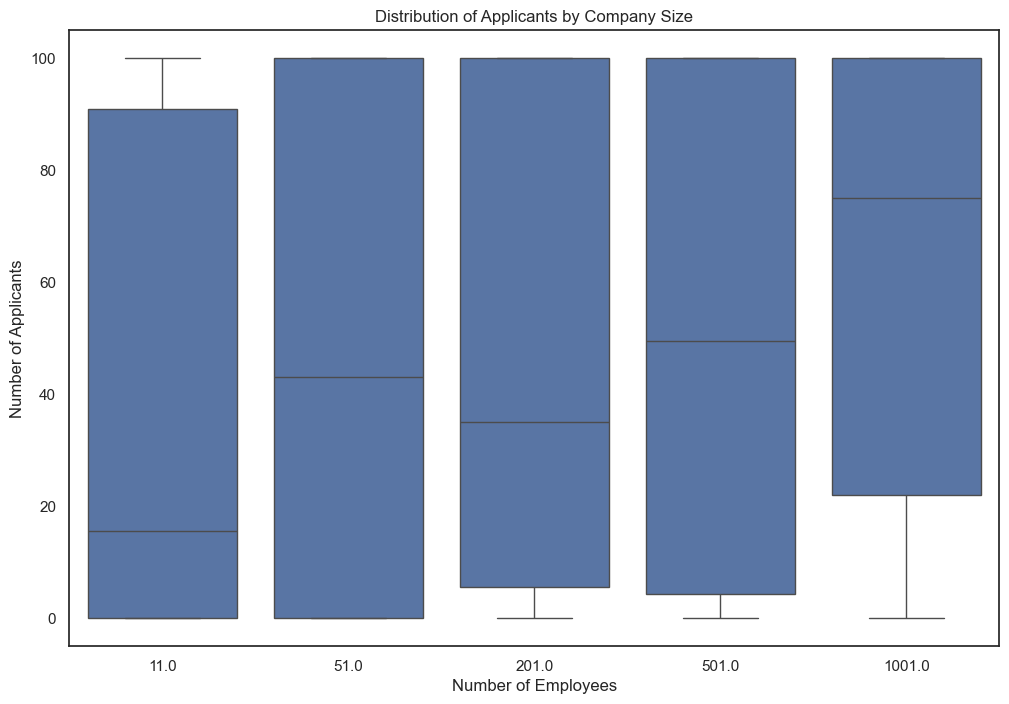

In [ ]:
# Define plot directory
plot_dir = 'C:\\Users\\thisi\\code\\DataCareerAnalysis\\plots'  # Update this path as needed

# Create boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x='Employees', y='Applicants', data=df_combined)  # Removed palette parameter

# Plot customization
plt.title('Distribution of Applicants by Company Size')
plt.xlabel('Number of Employees')
plt.ylabel('Number of Applicants')

# Define plot filename
plot_filename = os.path.join(plot_dir, 'Distribution of Applicants by Company Size.png')

# Ensure the directory exists
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

# Save and show the plot
plt.savefig(plot_filename)
plt.show()


## Percentage of applicants for each company size

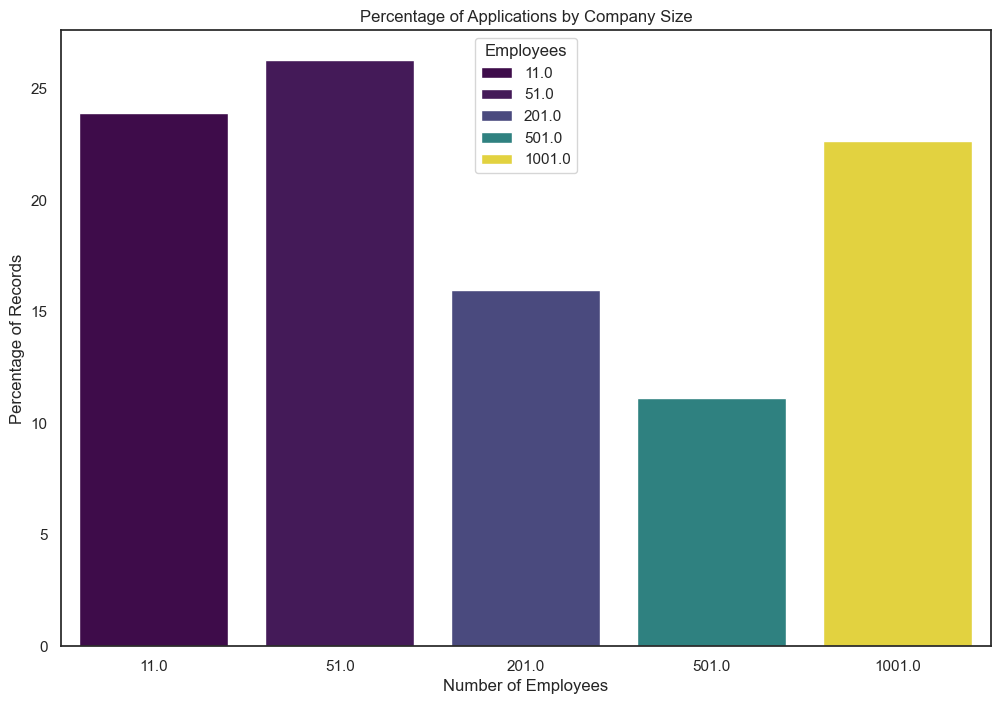

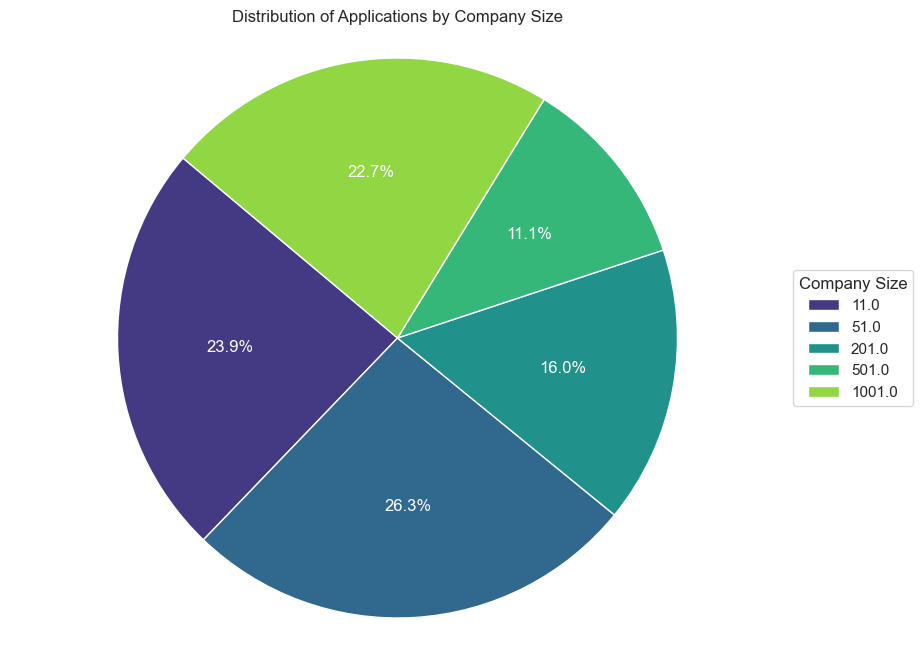

In [ ]:
# Count the number of applications for each company size
company_size_counts = df_combined['Employees'].value_counts().sort_index()
company_size_percentages = (company_size_counts / company_size_counts.sum()) * 100

# Plot the bar chart of record counts vs company size 
plt.figure(figsize=(12, 8))
sns.barplot(x=company_size_counts.index, y=company_size_percentages, hue=company_size_counts.index, palette='viridis')
plt.title('Percentage of Applications by Company Size')
plt.xlabel('Number of Employees')
plt.ylabel('Percentage of Records')

# Format x-axis ticks to display integers
plt.xticks(ticks=range(len(company_size_counts.index)), labels=company_size_counts.index)

plot_filename = os.path.join(plot_dir, 'Percentage of Applications by Company Size.png')
plt.savefig(plot_filename)
plt.show()

# Choose a color palette
colors = sns.color_palette("viridis", n_colors=len(company_size_counts))

# Plot the pie chart of record counts vs company size
plt.figure(figsize=(10, 8))
wedges, texts, autotexts = plt.pie(
    company_size_counts,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    textprops=dict(color="w")
)

plt.legend(wedges, company_size_counts.index, title="Company Size", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.title('Distribution of Applications by Company Size')
plt.axis('equal')  
plot_filename = os.path.join(plot_dir, 'Distribution of Applications by Company Size.png')
plt.savefig(plot_filename)
plt.show()


In [ ]:
# # Function to save all figures
# def save_all_figures():
#     fig_nums = plt.get_fignums()  # Get all figure numbers
#     for i, fig_num in enumerate(fig_nums):
#         fig = plt.figure(fig_num)  # Get the figure by number
#         fig.savefig(f"example_plot_{i+1}.png")  # Save the figure
#         plt.close(fig)  # Close the figure to free memory

# # Save all figures at the end of the notebook
# save_all_figures()